# Report: Data Science, Machine Learning & IA 
**University of Geneva**

**Author**: Reda Zahri

**Date**: January 2026

**Affiliation**: Veterinary Public Health Institute, University of Bern

---

## **Project** : Topic Modeling on Scientific Abstracts in Dairy Cattle Research
**Reconsidering Determinants of Health for Dairy Cattle as a Veterinary Public Health Challenge**

---

## 1. Problem Selection

### 1.1 Application Domain

**Veterinary Public Health** - specifically focused on dairy cattle health and welfare.

### 1.2 Problem Statement

Dairy cattle health is traditionally assessed through narrow clinical indicators (mostly disease prevalence). However, the **One Health** approach recognizes that animal health is influenced by multiple interconnected factors:

*Non-exhaustive list* :
- **Biological factors**: genetics, disease, reproduction
- **Environmental factors**: housing, climate, biosecurity
- **Nutritional factors**: diet quality, feeding management
- **Management factors**: farming practices, technology adoption
- **Socio-economic factors**: market pressures, policy, farmer knowledge

**Research Question:**
*What are the major thematic areas (topics) in dairy cattle research from 2000-2025, and how do they relate to the Determinants of Health framework?*

### 1.3 Objective

Using **unsupervised topic modeling** on scientific abstracts, we aim to:

1. Identify major research themes in dairy cattle literature (2000-2025)
2. Characterize each theme using LLM-based refinement
3. Map discovered topics to Determinants of Health categories
4. Reveal potential gaps or emerging areas in dairy cattle health research

### 1.4 Methodological Approach

We implement a **step-by-step enhanced reproduction of the BERTopic algorithm with LLMs applications** :

- **Embedding**: Fine-tuned sentence-transformers (PubMedBERT) to vectorize abstracts based on specific content (scientific biomedical corpora)
- **Dimensionality Reduction**: UMAP to reduce embedding dimensions
- **Clustering**: HDBSCAN for density-based topic discovery
- **Topic Representation**: c-TF-IDF for keyword extraction
- **Refinement**: LLM-based analysis to generate interpretable topic labels and link to Determinants of Health

This approach allows flexibility, transparency, and deeper understanding compared to using BERTopic as a black-box tool.

Source of BERTopic algorithm : https://maartengr.github.io/BERTopic/index.html

## 2. Data Collection

### 2.0 Environment Setup

In [45]:
# activate the correct environment
# selecting the correct kernel/python environment in jupyter notebook: "unige_data_science"

# import libraries
import os
import re
import json
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import string
import nltk
from nltk.corpus import stopwords
import faiss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer, models
import umap
from hdbscan import HDBSCAN
import pickle
from scipy.sparse import load_npz, save_npz, csr_matrix
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
from huggingface_hub import login
import time
import networkx as nx
from collections import Counter, defaultdict
import warnings
from itertools import product
from gensim.corpora import Dictionary
from tqdm.auto import tqdm 
warnings.filterwarnings('ignore')


# downloads and configurations
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))
vectorizer = TfidfVectorizer()
#login(token="<YOUR_TOKEN>")  # replace with your token

# get to current working directory
#os.chdir("<YOUR_PROJECT_DIRECTORY>")  # replace with your project directory
cwd = os.getcwd()

# create a data directory if it does not exist
data_dir = os.path.join(cwd, "data")


### 2.1 Data Sources

We collected scientific abstracts from **two major open-access biomedical databases**:

1. **PubMed** (U.S. National Library of Medicine)
   - Access: PubMed E-utilities API
   - Search query: (secret before official publication) ~ "dairy cattle" OR "dairy cows" OR "dairy farming"
   - Time range: 2000-2025
   
2. **Scopus** (Elsevier)
   - Access: Scopus API
   - Search query: (secret before official publication) ~ "dairy cattle" OR "dairy cows" OR "dairy farming"
   - Time range: 2000-2025

### 2.2 Data Acquisition

**Note on Data Restrictions:**
For professional confidentiality reasons, the datasets are restricted. In this report, we work with:
- PubMed: 5,000 randomly sampled records
- Scopus: 5,000 randomly sampled records
- **Total initial dataset: 10'000 abstracts**

### 2.3 Collected Metadata

For each publication, we collected:

| Field | Description | Source |
|-------|-------------|--------|
| **DOI** | Digital Object Identifier | Both |
| **Title** | Article title | Both |
| **Abstract** | Full abstract text | Both |
| **Authors** | Author list | Both |
| **Journal** | Publication venue | Both |
| **Year** | Publication year | Both |

*Where Scopus dataset has many other columns that will be discard to harmonize with PubMed dataset*

In [11]:
# import the datasets
pubmed_df = pd.read_csv("data/pubmed_5000.csv")
scopus_df = pd.read_csv("data/scopus_5000.csv")

# explore the datasets
print("First dataset (PubMed):")
print(f"the dimensions of the pubmed_df are {pubmed_df.shape}")
print("Name of the columns:", pubmed_df.columns.tolist())

print("\nSecond dataset (Scopus):")
print(f"the dimensions of the scopus_df are {scopus_df.shape}")
print("Name of the columns:", scopus_df.columns.tolist())

First dataset (PubMed):
the dimensions of the pubmed_df are (5000, 7)
Name of the columns: ['Title', 'Abstract', 'Authors', 'Year', 'Journal', 'DOI', 'Link']

Second dataset (Scopus):
the dimensions of the scopus_df are (5000, 37)
Name of the columns: ['eid', 'doi', 'pii', 'pubmed_id', 'title', 'subtype', 'subtypeDescription', 'creator', 'afid', 'affilname', 'affiliation_city', 'affiliation_country', 'author_count', 'author_names', 'author_ids', 'author_afids', 'coverDate', 'coverDisplayDate', 'publicationName', 'issn', 'source_id', 'eIssn', 'aggregationType', 'volume', 'issueIdentifier', 'article_number', 'pageRange', 'description', 'authkeywords', 'citedby_count', 'openaccess', 'freetoread', 'freetoreadLabel', 'fund_acr', 'fund_no', 'fund_sponsor', 'abstract']


## 3. Data Preparation

Regroup the two sub-dataset into a whole unique main one, with according columns.

---

### 3.1 Data Preprocessing

Before going further on the analysis, we need to work on the main "raw" dataset.

**Steps** :
1) Standardization of text corpora for future NLP process
2) Remove *exact* duplicates from the main dataset
3) Check for potential duplicates

In [12]:
# rename columns of scopus_df to match pubmed_df
scopus_df = scopus_df.rename(columns={
    'doi': 'DOI',
    'title': 'Title',
    'abstract': 'Abstract',
    'creator': 'Authors',
    'publicationName': 'Journal',
    'coverDate': 'Year'
})

# Add a column "source" to identify the origin of each record
pubmed_df["source"] = "pubmed"
scopus_df["source"] = "scopus"

# concatenate the two datasets
combined_df = pd.concat([pubmed_df, scopus_df], ignore_index=True)
print(f"The combined dataset has dimensions: {combined_df.shape}")

# drop the unnecessary columns of scopus_df
combined_df = combined_df[['DOI', 'Title', 'Abstract', 'Authors', 'Journal', 'Year', 'source']]
print(f"After dropping unnecessary columns, the combined dataset has dimensions: {combined_df.shape}")

The combined dataset has dimensions: (10000, 39)
After dropping unnecessary columns, the combined dataset has dimensions: (10000, 7)


In [13]:
# 1) threat the text data: lowercase, remove punctuation, remove stopwords
def clean_text(text):
    if pd.isnull(text):
        return ""
    # lowercase
    text = text.lower()
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

combined_df['Cleaned_Abstract'] = combined_df['Abstract'].apply(clean_text)
print("First abstract after cleaning:")
print(f"{combined_df['Cleaned_Abstract'].iloc[0][:100]}...")  # print first 500 characters of the first cleaned abstract for a better view

First abstract after cleaning:
vitamin va deficiency major health issue globally lactating women particularly vulnerable due increa...


In [14]:
# 2) removing exact duplicate records based on cleaned abstracts
initial_count = combined_df.shape[0]
combined_no_dup_df = combined_df.drop_duplicates(subset=['Cleaned_Abstract'])
final_count = combined_no_dup_df.shape[0]
print(f"Number of records before removing duplicates: {initial_count}")
print(f"Number of records after removing duplicates: {final_count}")
print(f"Number of duplicate records removed: {initial_count - final_count}")

Number of records before removing duplicates: 10000
Number of records after removing duplicates: 9167
Number of duplicate records removed: 833


In [15]:
# 3) checking for potential duplicates based on abstract similarity using FAISS
# for efficiency, we will create a subset of 2000 records and annotate for duplicates there
# then we will remove the duplicates from the full dataset based on the similarity threshold fixed from the subset annotation
subset_df = combined_no_dup_df.sample(n=2000, random_state=42).reset_index(drop=True)
subset_abstracts = (
    subset_df["Cleaned_Abstract"]
    .fillna("")
    .astype(str)
    .tolist()
)

# Vectorize the cleaned abstracts using TF-IDF from the subset
tfidf_matrix = vectorizer.fit_transform(subset_abstracts).astype(np.float32)

# Convert the sparse matrix to a dense format
dense_matrix = tfidf_matrix.toarray().astype('float32')

# normalize the vectors
dense_matrix = normalize(dense_matrix, axis=1, norm='l2').astype('float32')

# Build the FAISS index
dimension = dense_matrix.shape[1]
index = faiss.IndexFlatIP(dimension)  # Inner Product (for cosine similarity with normalized vectors)
index.add(dense_matrix)

# Search for nearest neighbors
k = 10  # number of nearest neighbors to search for
similarities, indices = index.search(dense_matrix, k)

# Identify potential duplicates based on a similarity threshold
similarity_threshold = 0.4
duplicate_pairs = []
seen_pairs = set()

# check the similarities and collect pairs above the threshold, with their indices, titles and authors
# also add an empty column to label them as duplicates later
for i in range(similarities.shape[0]):
    for rank in range(1, k):  # skip rank=0 (itself)
        j = int(indices[i, rank])
        sim = float(similarities[i, rank])

        # sometimes FAISS can return i itself again in later ranks (rare, but happens)
        if j == i:
            continue

        if sim < similarity_threshold:
            continue

        # store unique unordered pair
        a, b = (i, j) if i < j else (j, i)
        if (a, b) in seen_pairs:
            continue
        seen_pairs.add((a, b))

        duplicate_pairs.append({
            "Index1": a,
            "Index2": b,
            "Similarity": sim,
            "Title1": subset_df.loc[a, "Title"],
            "Title2": subset_df.loc[b, "Title"],
            "Authors1": subset_df.loc[a, "Authors"],
            "Authors2": subset_df.loc[b, "Authors"],
            "Year1": subset_df.loc[a, "Year"],
            "Year2": subset_df.loc[b, "Year"],
            "Is_Duplicate": ""
        })

duplicates_df = pd.DataFrame(duplicate_pairs).sort_values("Similarity", ascending=False)
duplicates_df.to_csv("data/potential_duplicates.csv", index=False)

In [16]:
# 3...) after manual review of the potential duplicates in "potential_duplicates.csv",
# we do not find any duplicates below similarity threshold of 0.7
# we will remove the duplicates from the full dataset at a threshold of 0.7 to balance between removing true positives and keeping false positives
similarity_threshold = 0.7

# IMPORTANT: ensure index is positional 0..n-1 so drop(index=...) is correct
df = combined_no_dup_df.reset_index(drop=True).copy()
abstracts = df["Cleaned_Abstract"].fillna("").astype(str).tolist()

# Vectorize the cleaned abstracts using TF-IDF, same as before
tfidf_matrix = vectorizer.fit_transform(abstracts).astype(np.float32)

# Filter out all-zero TF-IDF rows (empty / fully removed by cleaning)
row_sums = np.asarray(tfidf_matrix.sum(axis=1)).ravel()
keep = row_sums > 0
tfidf_matrix = tfidf_matrix[keep]
df_kept = df.loc[keep].reset_index(drop=True)

# DENSE (warning: can be huge if TF-IDF vocab is huge)
dense_matrix = tfidf_matrix.toarray().astype("float32")
dense_matrix = normalize(dense_matrix, axis=1, norm="l2").astype("float32")

d = dense_matrix.shape[1]
index = faiss.IndexFlatIP(d)
index.add(dense_matrix)

k = 10  # 5 is small, 10 is safer for removing real duplicates above threshold
similarities, indices = index.search(dense_matrix, k)

duplicate_pairs = []
seen_pairs = set()

for i in range(similarities.shape[0]):
    for rank in range(1, k):
        j = int(indices[i, rank])
        sim = float(similarities[i, rank])
        if j == i:
            continue
        if sim < similarity_threshold:
            continue

        a, b = (i, j) if i < j else (j, i)
        if (a, b) in seen_pairs:
            continue
        seen_pairs.add((a, b))
        duplicate_pairs.append((a, b, sim))

# indices to remove (keep the smaller index by default)
indices_to_remove = {b for (a, b, sim) in duplicate_pairs} # we might get less rows removed than num of pairs if some b are repeated

combined_final_df = df_kept.drop(index=list(indices_to_remove)).reset_index(drop=True)

print(f"Pairs found >= {similarity_threshold}: {len(duplicate_pairs)}")
print(f"Rows removed: {len(indices_to_remove)}")
print(f"Final dataset dimensions: {combined_final_df.shape}")

combined_final_df.to_csv("data/cleaned_combined_dataset.csv", index=False)

Pairs found >= 0.7: 294
Rows removed: 293
Final dataset dimensions: (8873, 8)


### 4. Data Exploratory Analysis (AED) & Data Pre-visualization

Before diving into the core topic modeling pipeline, we conduct an exploratory analysis of the cleaned dataset to understand temporal trends, publication patterns, and collaboration networks in dairy cattle research. This pre-visualization phase provides essential context for interpreting our topic modeling results and helps validate data quality.

#### 4.1 Temporal Analysis

**Understand the evolution of dairy cattle research from 2000 to 2025.**

Research publication patterns reveal important insights about the field's development, emerging priorities, and response to global challenges (e.g., disease outbreaks, climate change, sustainability concerns). By analyzing temporal trends, we can:

- Identify periods of increased research activity
- Detect potential shifts in research focus over time
- Understand the growth trajectory of the field
- Establish baseline patterns before topic-specific temporal analysis

**Analyses Performed:**
1. **Overall Publication Trends:** Annual publication counts (2000-2025)
2. **Cumulative Growth:** Total accumulated publications over time
3. **Period-based Analysis:** Publications grouped into 5-year periods
4. **Year-over-Year Growth Rate:** Annual percentage change in publication volume
5. **Trend Analysis:** Linear regression to quantify overall direction

Data range: 2000 - 2025
Total documents: 8605

Year values sample:
Year
2000      71
2001      58
2002      74
2003      72
2004      76
2005     132
2006     131
2007     155
2008     150
2009     167
2010      85
2011     185
2012     233
2013     279
2014     265
2015     313
2016     320
2017     255
2018     415
2019     444
2020     628
2021     821
2022     791
2023     843
2024    1011
2025     631
Name: count, dtype: int64


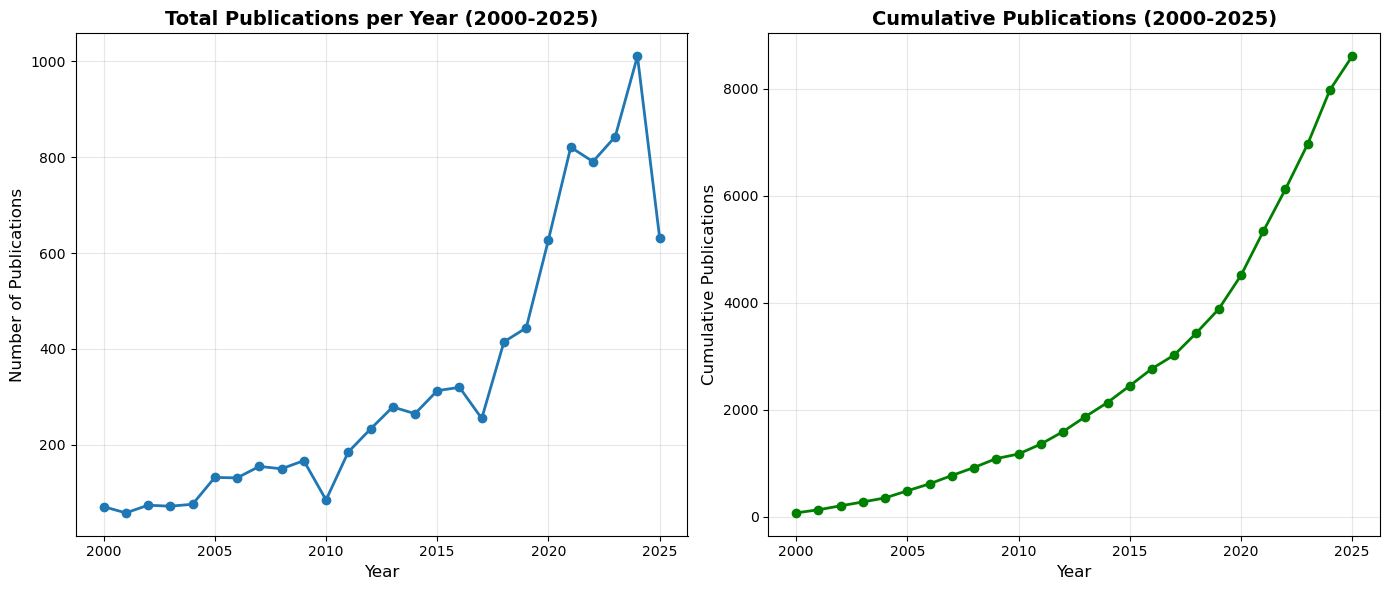


Publications by period:
Period
2000-2004     351
2005-2009     735
2010-2014    1047
2015-2019    1747
2020-2025    4725
Name: count, dtype: int64


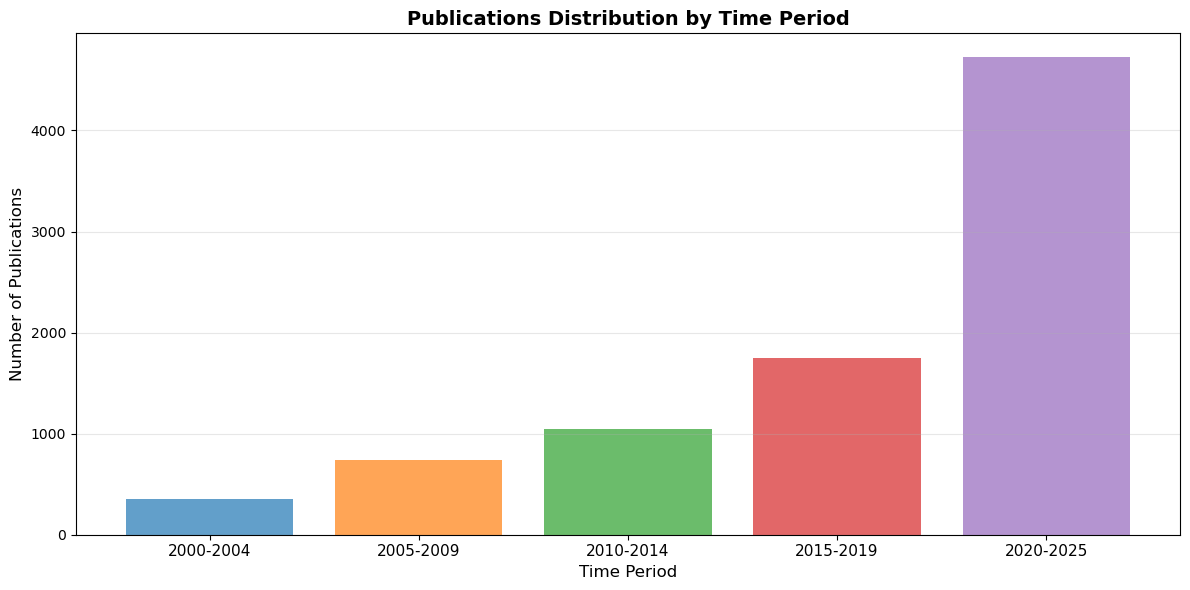


Years with highest growth:
  2011: +117.6% (185 publications)
  2005: +73.7% (132 publications)
  2018: +62.7% (415 publications)
  2020: +41.4% (628 publications)
  2021: +30.7% (821 publications)

Years with biggest decline:
  2010: -49.1% (85 publications)
  2025: -37.6% (631 publications)
  2017: -20.3% (255 publications)
  2001: -18.3% (58 publications)
  2014: -5.0% (265 publications)


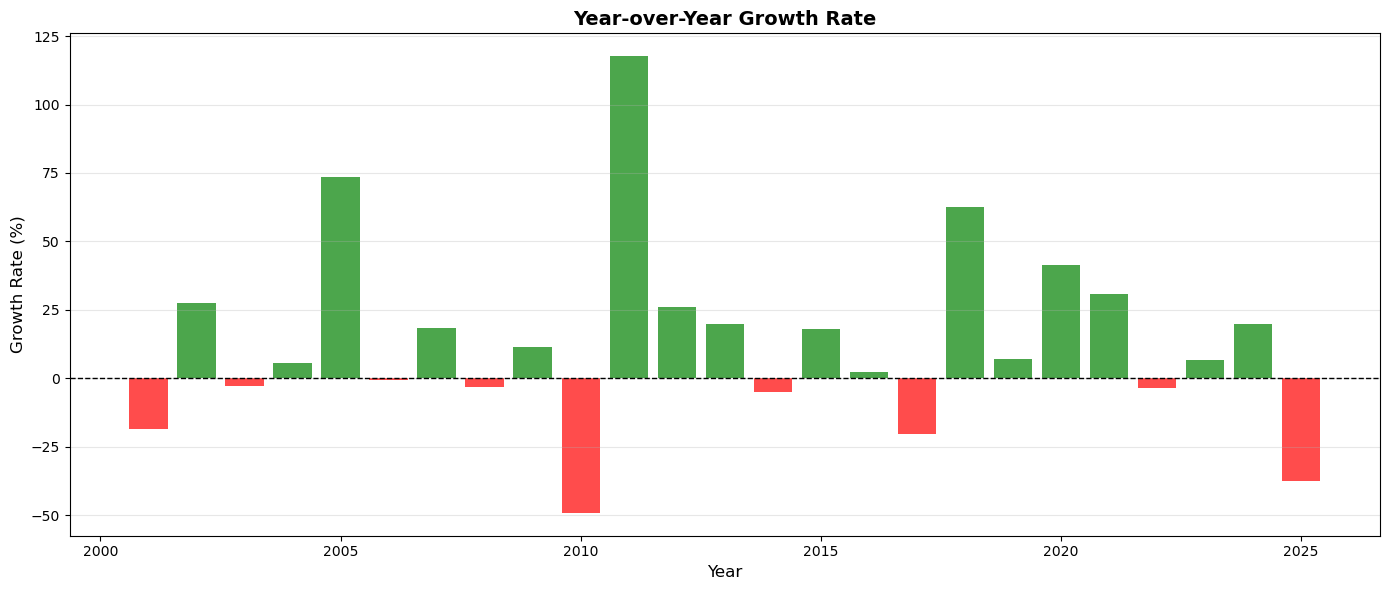


Statistical Summary:
  Mean publications per year: 331.0
  Median publications per year: 244.0
  Std deviation: 282.1
  Peak year: 2024 (1011 publications)
  Lowest year: 2001 (58 publications)

Overall trend: +32.89 publications/year
Publications are increasing over time


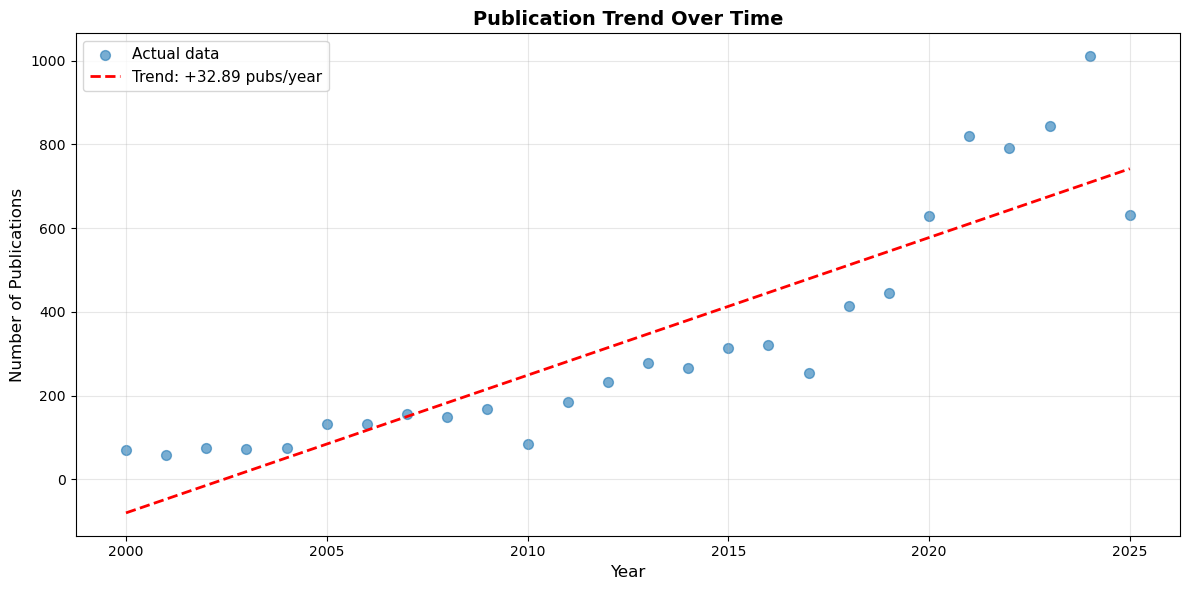

In [20]:
# 4.1 Temporal Analysis
# Load cleaned dataset
cleaned_df = pd.read_csv("data/cleaned_combined_dataset.csv")

# Harmonize Year column (handle both float and date formats)
def extract_year(year_value):
    """
    Extract year from different formats:
    - Float: 2020.0 -> 2020
    - String date: '2020-01-15' -> 2020
    - String year: '2020' -> 2020
    """
    if pd.isna(year_value):
        return np.nan
    
    # convert to string first
    year_str = str(year_value).strip()
    
    # if it's a date format (yyyy-mm-dd or yyyy-mm or similar)
    if '-' in year_str:
        year_str = year_str.split('-')[0]
    
    # if it's a float format (2020.0)
    if '.' in year_str:
        year_str = year_str.split('.')[0]
    
    # try to convert to integer
    try:
        year_int = int(year_str)
        # validate year is in reasonable range
        if 1900 <= year_int <= 2030:
            return year_int
        else:
            return np.nan
    except:
        return np.nan

# apply year extraction
cleaned_df['Year'] = cleaned_df['Year'].apply(extract_year)

# filter valid years
cleaned_df = cleaned_df[cleaned_df['Year'].notna()]
cleaned_df = cleaned_df[(cleaned_df['Year'] >= 2000) & (cleaned_df['Year'] <= 2025)]

# convert to int for cleaner display
cleaned_df['Year'] = cleaned_df['Year'].astype(int)

print(f"Data range: {cleaned_df['Year'].min()} - {cleaned_df['Year'].max()}")
print(f"Total documents: {len(cleaned_df)}")

# check year format distribution
print(f"\nYear values sample:")
print(cleaned_df['Year'].value_counts().sort_index())

# 1) overall publications per year
year_counts = cleaned_df['Year'].value_counts().sort_index()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(year_counts.index, year_counts.values, marker='o', linewidth=2, markersize=6)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Publications', fontsize=12)
plt.title('Total Publications per Year (2000-2025)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# 2) cumulative publications
plt.subplot(1, 2, 2)
cumulative = year_counts.cumsum()
plt.plot(cumulative.index, cumulative.values, marker='o', linewidth=2, markersize=6, color='green')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Cumulative Publications', fontsize=12)
plt.title('Cumulative Publications (2000-2025)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('output/figures/temporal_analysis_overall.png', dpi=300, bbox_inches='tight')
plt.show()

# 3) publications by time periods
period_bins = [2000, 2005, 2010, 2015, 2020, 2026]
period_labels = ['2000-2004', '2005-2009', '2010-2014', '2015-2019', '2020-2025']
cleaned_df['Period'] = pd.cut(cleaned_df['Year'], bins=period_bins, labels=period_labels, right=False)

period_counts = cleaned_df['Period'].value_counts().sort_index()
print(f"\nPublications by period:")
print(period_counts)

plt.figure(figsize=(12, 6))
plt.bar(range(len(period_counts)), period_counts.values, 
        color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'], alpha=0.7)
plt.xticks(range(len(period_counts)), period_counts.index, fontsize=11)
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('Number of Publications', fontsize=12)
plt.title('Publications Distribution by Time Period', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('output/figures/temporal_periods.png', dpi=300, bbox_inches='tight')
plt.show()

# 4) year-over-year growth rate
year_counts_sorted = year_counts.sort_index()
growth_rates = year_counts_sorted.pct_change() * 100

print(f"\nYears with highest growth:")
top_growth = growth_rates.nlargest(5)
for year, rate in top_growth.items():
    print(f"  {year}: {rate:+.1f}% ({year_counts_sorted[year]} publications)")

print(f"\nYears with biggest decline:")
top_decline = growth_rates.nsmallest(5)
for year, rate in top_decline.items():
    print(f"  {year}: {rate:+.1f}% ({year_counts_sorted[year]} publications)")

plt.figure(figsize=(14, 6))
colors = ['green' if x > 0 else 'red' for x in growth_rates.values]
plt.bar(growth_rates.index, growth_rates.values, color=colors, alpha=0.7)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Growth Rate (%)', fontsize=12)
plt.title('Year-over-Year Growth Rate', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('output/figures/temporal_growth_rates.png', dpi=300, bbox_inches='tight')
plt.show()

# 5) statistical summary and trend
print(f"\nStatistical Summary:")
print(f"  Mean publications per year: {year_counts.mean():.1f}")
print(f"  Median publications per year: {year_counts.median():.1f}")
print(f"  Std deviation: {year_counts.std():.1f}")
print(f"  Peak year: {year_counts.idxmax()} ({year_counts.max()} publications)")
print(f"  Lowest year: {year_counts.idxmin()} ({year_counts.min()} publications)")

# calculate linear trend
years = year_counts.index.values
counts = year_counts.values
z = np.polyfit(years, counts, 1)
p = np.poly1d(z)

print(f"\nOverall trend: {z[0]:+.2f} publications/year")
if z[0] > 0:
    print("Publications are increasing over time")
else:
    print("Publications are decreasing over time")

plt.figure(figsize=(12, 6))
plt.scatter(years, counts, alpha=0.6, s=50, label='Actual data')
plt.plot(years, p(years), "r--", linewidth=2, label=f'Trend: {z[0]:+.2f} pubs/year')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Publications', fontsize=12)
plt.title('Publication Trend Over Time', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('output/figures/temporal_trend.png', dpi=300, bbox_inches='tight')
plt.show()

**Analysis of temporal patterns in dairy cattle health research**

We observe an mild exponential-like increase over the years of the number of publication each year in this specific field. With 2020-2025 having more than the half of all publications published.

Despite the limitation of having a very restricted dataset, the available data reveals an upward trend in dairy cattle health research within the veterinary medicine field. Publications increased from 71 in 2000 to 1,011 in 2024, suggesting growing interest and activity in this research area over the past two decades.

#### 4.2 Journal Distribution Analysis

**Identify the primary publication venues and their relationship to research topics.**

Understanding where dairy cattle research is published provides insights into the field's interdisciplinary nature and helps assess the comprehensiveness of our data collection. Different journals may specialize in specific aspects of dairy cattle health (e.g., nutrition, reproduction, disease management), and this specialization may influence topic distribution. Core veterinary journals (e.g., *Journal of Dairy Science*, *Preventive Veterinary Medicine*) likely dominate. Interdisciplinary journals may indicate cross-cutting topics (e.g., economics, sustainability).

**Analyses Performed:**
1. **Top Journals Overall:** Ranking journals by total publication count
2. **Journal Diversity Metrics:** Number of unique journals per topic
3. **Topic Distribution by Journal:** How topics are represented in leading journals

Top 15 Journals by Publication Count:
Journal_clean
Journal of Dairy Science           739
Nutrients                          207
Animals                            166
Preventive Veterinary Medicine     116
PLoS ONE                           103
Animal                              90
Scientific Reports                  87
Frontiers in Veterinary Science     85
Foods                               59
Trop Anim Health Prod               58
Frontiers in Microbiology           53
Plos One                            43
J Anim Sci                          41
Am J Clin Nutr                      40
BMC Vet Res                         38
Name: count, dtype: int64


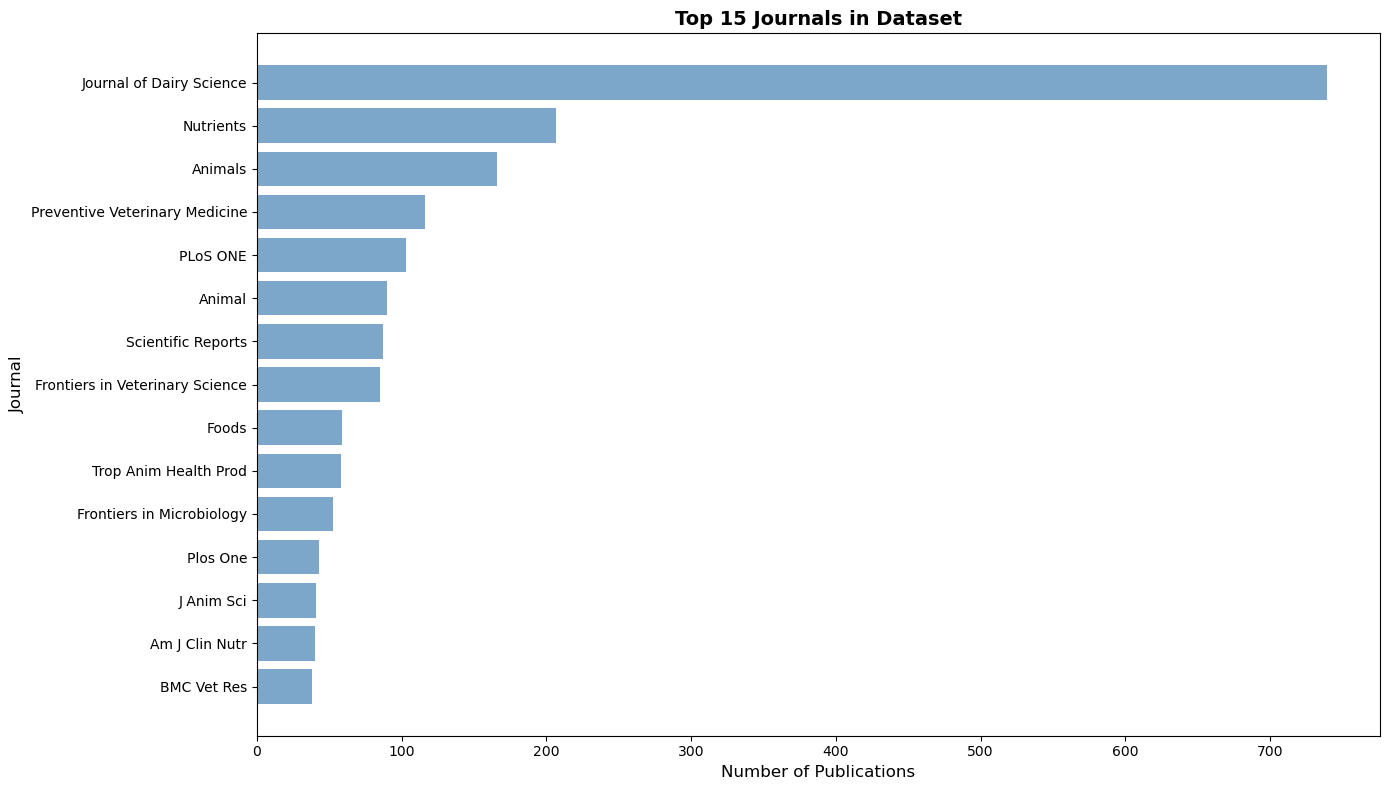


Total unique journals: 2855
Publications in top 10 journals: 1710 (19.9%)

Journal name harmonization impact:
  'Journal of Dairy Science' total: 739
  'Preventive Veterinary Medicine' total: 116
  'Scientific Reports' total: 87


In [21]:
# 4.2 Journal Distribution Analysis

# check if Journal column exists
if 'Journal' in cleaned_df.columns:
    # clean journal names
    cleaned_df['Journal_clean'] = cleaned_df['Journal'].fillna('Unknown').str.strip()
    
    # harmonize journal names (map variations to standard names)
    journal_mapping = {
        # Journal of Dairy Science variations
        'J Dairy Sci': 'Journal of Dairy Science',
        'J. Dairy Sci.': 'Journal of Dairy Science',
        'J. Dairy Sci': 'Journal of Dairy Science',
        'JDS': 'Journal of Dairy Science',
        
        # Preventive Veterinary Medicine variations
        'Prev Vet Med': 'Preventive Veterinary Medicine',
        'Prev. Vet. Med.': 'Preventive Veterinary Medicine',
        'Prev. Vet. Med': 'Preventive Veterinary Medicine',
        
        # Scientific Reports variations
        'Sci Rep': 'Scientific Reports',
        'Sci. Rep.': 'Scientific Reports',
        'Sci. Rep': 'Scientific Reports',
        
        # Frontiers variations
        'Front Vet Sci': 'Frontiers in Veterinary Science',
        'Front. Vet. Sci.': 'Frontiers in Veterinary Science',
        'Front Microbiol': 'Frontiers in Microbiology',
        'Front. Microbiol.': 'Frontiers in Microbiology',
        
        # PLoS ONE variations
        'PLoS One': 'PLoS ONE',
        'PLOS ONE': 'PLoS ONE',
        'PloS one': 'PLoS ONE',
        
        # Animals variations
        'Animals (Basel)': 'Animals',
        'Animals : an open access journal from MDPI': 'Animals',
        
        # JDS Communications
        'JDS Commun': 'JDS Communications',
        'JDS Communications': 'JDS Communications',
    }
    
    # apply mapping
    cleaned_df['Journal_clean'] = cleaned_df['Journal_clean'].replace(journal_mapping)
    
    # 1) top journals overall
    print("Top 15 Journals by Publication Count:")
    top_journals = cleaned_df['Journal_clean'].value_counts().head(15)
    print(top_journals)
    
    plt.figure(figsize=(14, 8))
    plt.barh(range(len(top_journals)), top_journals.values, color='steelblue', alpha=0.7)
    plt.yticks(range(len(top_journals)), top_journals.index, fontsize=10)
    plt.xlabel('Number of Publications', fontsize=12)
    plt.ylabel('Journal', fontsize=12)
    plt.title('Top 15 Journals in Dataset', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('output/figures/journal_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2) journal diversity statistics
    n_unique_journals = cleaned_df['Journal_clean'].nunique()
    print(f"\nTotal unique journals: {n_unique_journals}")
    print(f"Publications in top 10 journals: {top_journals.head(10).sum()} ({top_journals.head(10).sum()/len(cleaned_df)*100:.1f}%)")
    
    # show before/after harmonization
    print(f"\nJournal name harmonization impact:")
    print(f"  'Journal of Dairy Science' total: {cleaned_df[cleaned_df['Journal_clean'] == 'Journal of Dairy Science'].shape[0]}")
    print(f"  'Preventive Veterinary Medicine' total: {cleaned_df[cleaned_df['Journal_clean'] == 'Preventive Veterinary Medicine'].shape[0]}")
    print(f"  'Scientific Reports' total: {cleaned_df[cleaned_df['Journal_clean'] == 'Scientific Reports'].shape[0]}")
    
else:
    print("Warning: 'Journal' column not found in dataset")

**Examining publication patterns across scientific journals**

The distribution of publications across journals follows an exponential pattern, with a small number of journals accounting for a disproportionate share of the research output. The journal Journal of Dairy Science stands out as clear outlier, representing ~10% of the publications within the top 10 journals. Collectively, the top 10 journals account for less than 20% of all publications in the dataset.

**Data Quality Note:** Journal names may exhibit inconsistencies due to abbreviations, punctuation variations, and formatting differences. The current analysis may not fully capture all instances of the same journal under different naming conventions, suggesting that further data harmonization could refine these results.

#### 4.3 Author Analysis

**Identify key researchers in dairy cattle science.**

*Note*: Scopus' format for Authors is only displaying the main one. Network analysis is then somewhat hard to do.

**Analyses Performed:**
1. **Collaboration Statistics:**
   - Distribution of authors per paper

2. **Prolific Authors:**
   - Top 20 most productive authors
   - Publication counts and trends

3. **Network Analysis (PubMed only):**
   - Co-authorship network among top authors
   - Network density and connectivity metrics
   - Identification of research communities and collaboration clusters
   
   *Note*: This analysis is limited to PubMed data where all co-authors are listed. Scopus data only provides the main author, making network analysis infeasible for those records.

*Note*: Scopus' format for Authors is only displaying the main one.
        Network analysis is then somewhat hard to do.

1. COLLABORATION STATISTICS

Total documents with authors: 8309
Average authors per paper: 3.36
Median authors per paper: 1.0
Max authors on a paper: 77

Author statistics by source:
  pubmed: avg=5.61, median=5.0
  scopus: avg=0.94, median=1.0


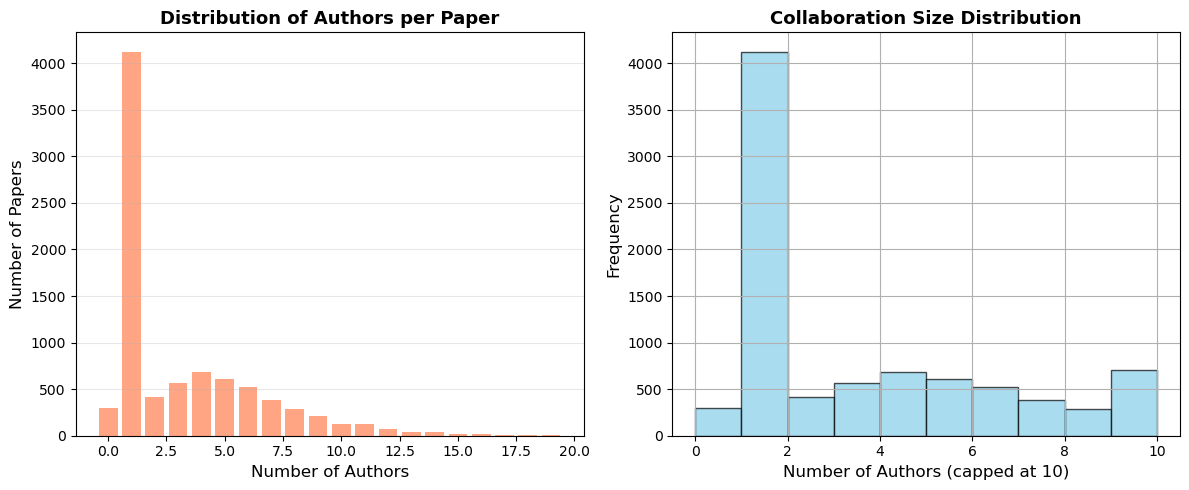


2. PROLIFIC AUTHORS

Top 20 Most Prolific Authors (excluding ambiguous + chinese-like names):
 1. LeBlanc SJ                                         :  20 publications
 2. Kelton DF                                          :  19 publications
 3. Renaud DL                                          :  19 publications
 4. Willett WC                                         :  19 publications
 5. Hogeveen H                                         :  18 publications
 6. Zebeli Q                                           :  18 publications
 7. Barkema HW                                         :  15 publications
 8. DeVries TJ                                         :  15 publications
 9. Santos JEP                                         :  15 publications
10. Dufour S                                           :  15 publications
11. Kumar A                                            :  14 publications
12. Roy JP                                             :  14 publications
13. Duffield TF  

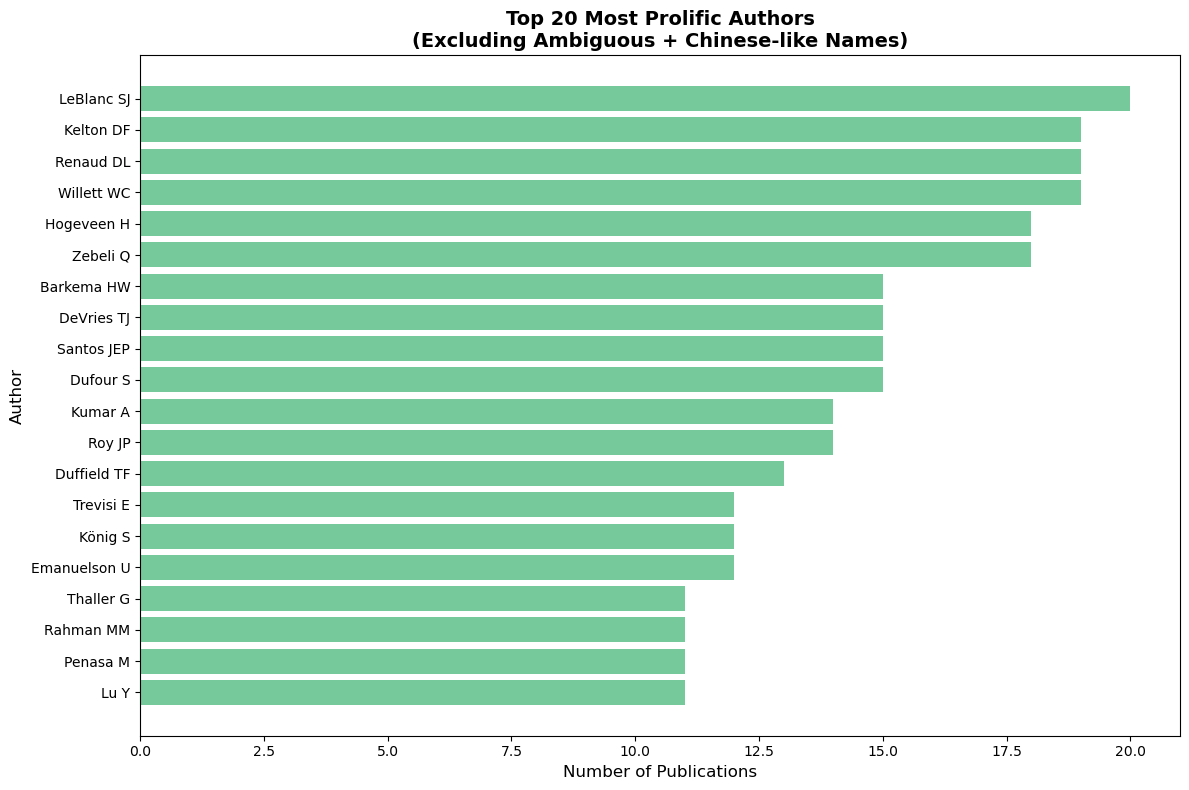


3. NETWORK ANALYSIS (PubMed only)

PubMed records for network analysis: 4471
PubMed records with multiple authors: 4183
Excluded chinese-like ambiguous names and generic initial-only names.
Building co-authorship network with top 50 PubMed authors...

Network Statistics:
  Nodes (authors): 41
  Edges (collaborations): 74
  Network density: 0.0902
  Connected components: 7

Most Connected Authors (Degree Centrality):
   1. Kelton DF                                     : 0.2750
   2. Renaud DL                                     : 0.2250
   3. LeBlanc SJ                                    : 0.2000
   4. Gilbert RO                                    : 0.1750
   5. Dubuc J                                       : 0.1750
   6. Roy JP                                        : 0.1750
   7. Barkema HW                                    : 0.1750
   8. Santos JEP                                    : 0.1750
   9. Dufour S                                      : 0.1750
  10. Chebel RC               

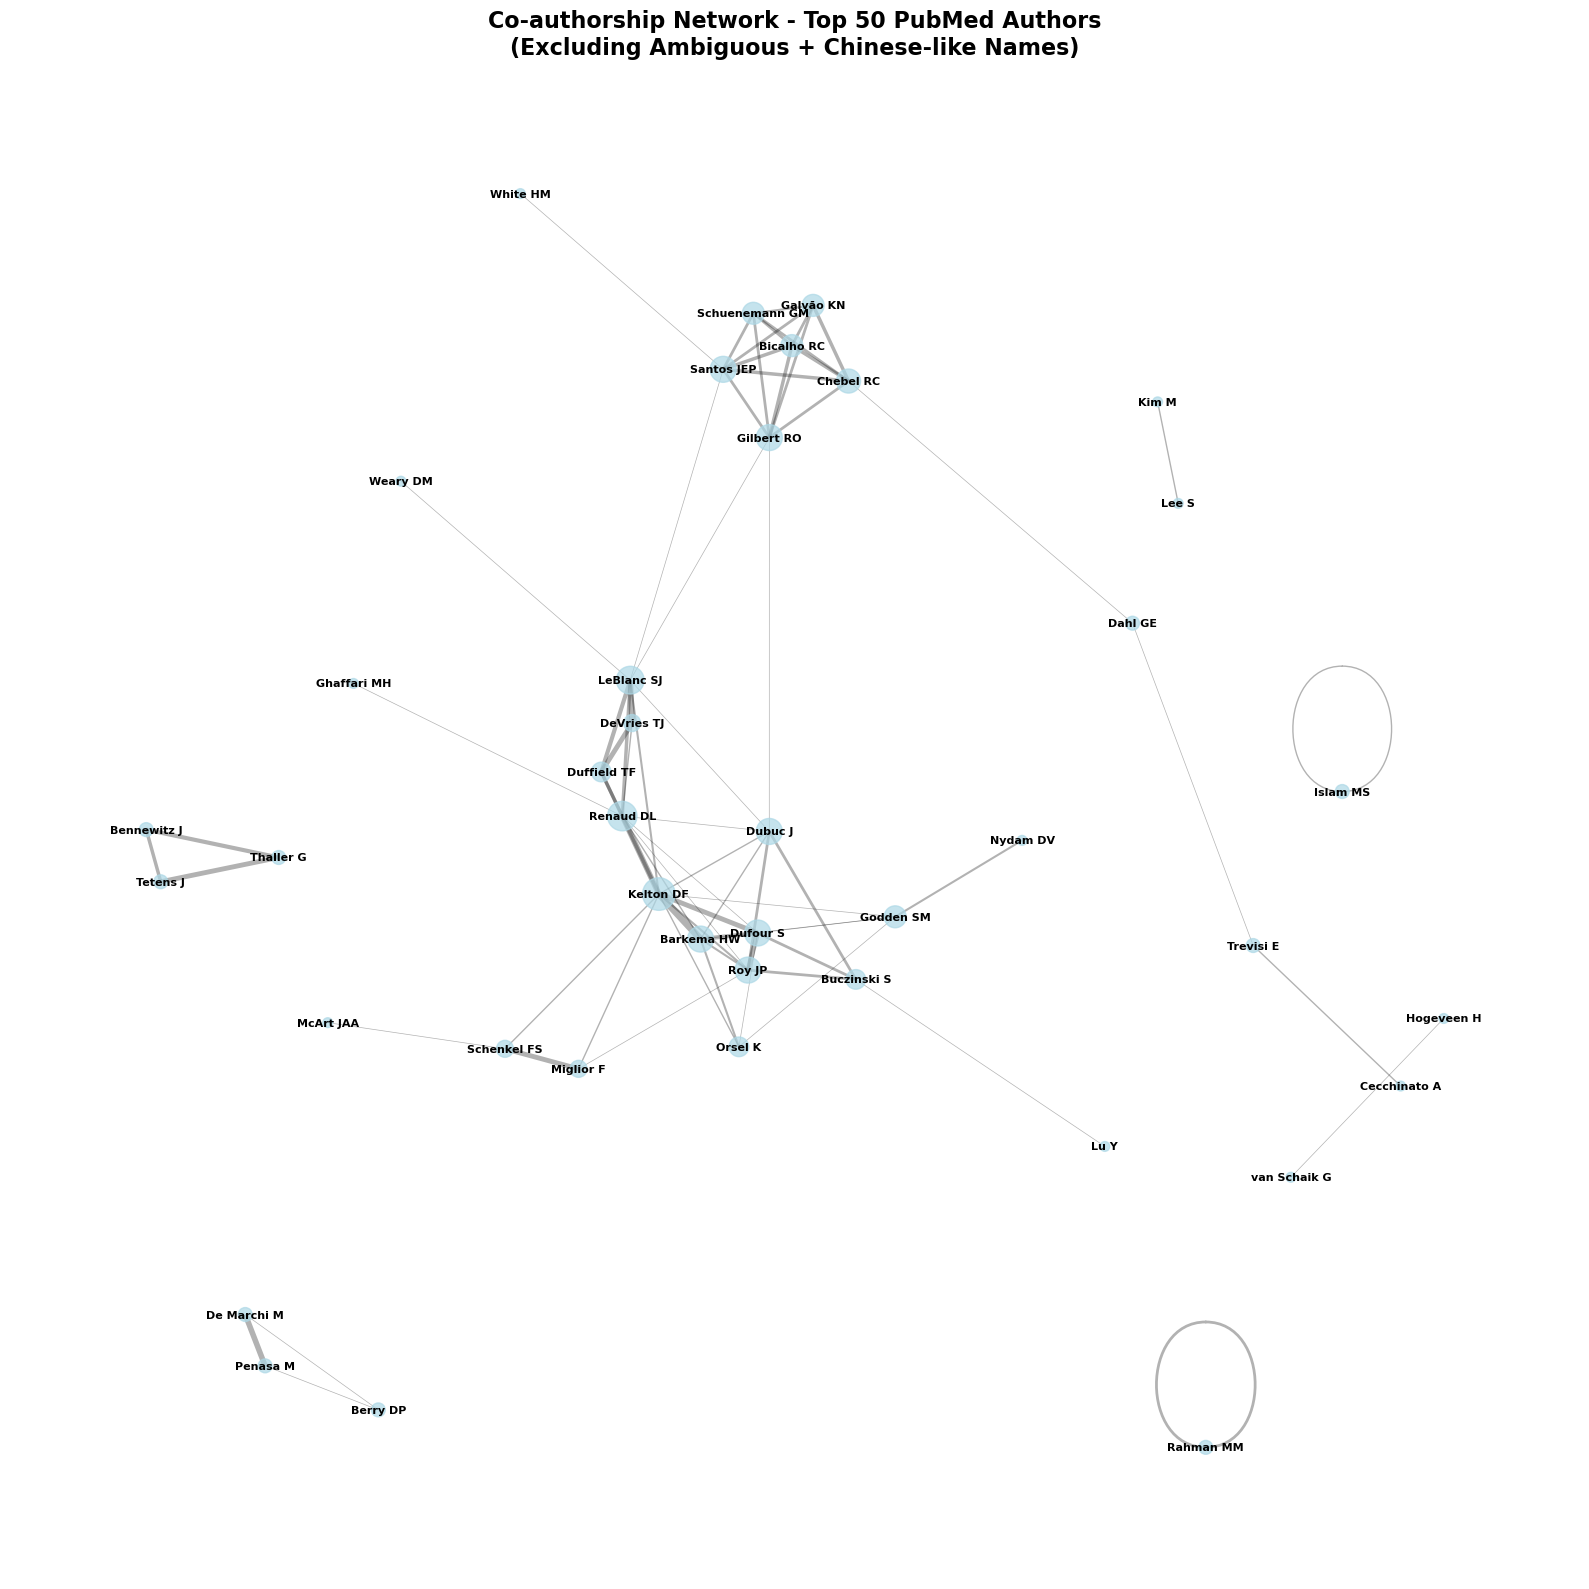


 Network visualization saved


In [22]:
# 4.3 Author Network Analysis
# check if Authors column exists
if 'Authors' in cleaned_df.columns:

    # ---------------------------------------------------------------------
    # 0) Helpers
    # ---------------------------------------------------------------------
    def normalize_author(author: str) -> str:
        """
        Standardize author strings so filters work.
        Removes quotes/brackets/punctuation noise and collapses whitespace.
        """
        if author is None:
            return ""

        a = str(author).strip()

        # remove outer brackets
        a = a.strip().strip("[](){}")

        # remove quotes anywhere + trim again
        a = a.replace("'", "").replace('"', "").replace("`", "")
        a = a.strip()

        # remove trailing punctuation
        a = re.sub(r"[.,;:]+$", "", a)

        # collapse whitespace
        a = " ".join(a.split())
        return a

    def is_likely_chinese_name(author: str) -> bool:
        """
        Detect likely Chinese names to exclude them entirely.
        Focused on common surname + initials patterns that create heavy ambiguity.
        """
        common_surnames = {
            'Wang','Li','Zhang','Liu','Chen','Yang','Huang','Zhao','Wu','Zhou','Xu',
            'Sun','Ma','Zhu','Hu','Guo','He','Gao','Lin','Luo','Song','Deng','Tang',
            'Feng','Cao','Jiang','Xie','Shen','Han','Yuan','Qin','Wei','Dong','Xiao'
        }

        a = normalize_author(author)
        if not a:
            return False

        parts = a.replace(".", "").split()

        # Wang Y / Li J / Zhang X
        if len(parts) == 2:
            surname, given = parts
            if surname in common_surnames and len(given) <= 2:
                return True

        # Wang Y J / Zhang X Y / Li J H (multi-initial)
        if len(parts) >= 3 and parts[0] in common_surnames:
            if all(len(p) <= 2 for p in parts[1:]):
                return True

        return False

    def is_ambiguous_name(author: str) -> bool:
        """
        Filter ambiguous names.
        NOW: Only filters Chinese surname + initial combos (already handled by is_likely_chinese_name).
        Allows European names like "Smith J" to pass through.
        """
        a = normalize_author(author)
        if not a:
            return True
        
        # Just check if it's a Chinese name (already defined)
        return is_likely_chinese_name(a)

    # ---------------------------------------------------------------------
    # 1) Parse Authors
    # ---------------------------------------------------------------------
    def parse_authors(author_string, source):
        """Parse authors from different formats and REMOVE chinese-like ambiguous names."""
        if pd.isna(author_string) or str(author_string).strip() == "":
            return []

        s = str(author_string).strip()
        s = s.replace("[", "").replace("]", "")

        # split logic (kept close to your original)
        if ";" in s:
            authors = [a.strip() for a in s.split(";")]
        else:
            # PubMed can sometimes be comma-separated; Scopus too in your dataset.
            authors = [a.strip() for a in s.split(",")]

        cleaned_authors = []
        for author in authors:
            author = normalize_author(author)

            if len(author) < 3:
                continue

            # remove chinese-like ambiguous names at ingestion
            if is_likely_chinese_name(author):
                continue

            cleaned_authors.append(author)

        return cleaned_authors

    # Apply parsing
    cleaned_df['Authors_list'] = cleaned_df.apply(
        lambda row: parse_authors(row['Authors'], row.get('source', '')),
        axis=1
    )

    # SAFETY NET: normalize again + ensure chinese names are removed (covers any weird edge cases)
    cleaned_df['Authors_list'] = cleaned_df['Authors_list'].apply(
        lambda lst: [normalize_author(a) for a in lst if a and not is_likely_chinese_name(a)]
    )

    cleaned_df['N_authors'] = cleaned_df['Authors_list'].apply(len)

    print("*Note*: Scopus' format for Authors is only displaying the main one.")
    print("        Network analysis is then somewhat hard to do.\n")

    # ---------------------------------------------------------------------
    # 1) Collaboration statistics
    # ---------------------------------------------------------------------
    print("=" * 80)
    print("1. COLLABORATION STATISTICS")
    print("=" * 80)

    print(f"\nTotal documents with authors: {cleaned_df['N_authors'].gt(0).sum()}")
    print(f"Average authors per paper: {cleaned_df['N_authors'].mean():.2f}")
    print(f"Median authors per paper: {cleaned_df['N_authors'].median():.1f}")
    print(f"Max authors on a paper: {cleaned_df['N_authors'].max()}")

    if 'source' in cleaned_df.columns:
        print(f"\nAuthor statistics by source:")
        for source in cleaned_df['source'].dropna().unique():
            source_data = cleaned_df[cleaned_df['source'] == source]
            if len(source_data) > 0:
                print(f"  {source}: avg={source_data['N_authors'].mean():.2f}, median={source_data['N_authors'].median():.1f}")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    author_counts_dist = cleaned_df['N_authors'].value_counts().sort_index()
    plt.bar(author_counts_dist.index[:20], author_counts_dist.values[:20], color='coral', alpha=0.7)
    plt.xlabel('Number of Authors', fontsize=12)
    plt.ylabel('Number of Papers', fontsize=12)
    plt.title('Distribution of Authors per Paper', fontsize=13, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)

    plt.subplot(1, 2, 2)
    collaboration_size = cleaned_df['N_authors'].clip(upper=10)
    collaboration_size.hist(bins=10, color='skyblue', alpha=0.7, edgecolor='black')
    plt.xlabel('Number of Authors (capped at 10)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Collaboration Size Distribution', fontsize=13, fontweight='bold')

    plt.tight_layout()
    plt.savefig('output/figures/author_collaboration_size.png', dpi=300, bbox_inches='tight')
    plt.show()

    # ---------------------------------------------------------------------
    # 2) Most prolific authors
    # ---------------------------------------------------------------------
    print("\n" + "=" * 80)
    print("2. PROLIFIC AUTHORS")
    print("=" * 80)

    all_authors = []
    for authors_list in cleaned_df['Authors_list']:
        all_authors.extend(authors_list)

    author_counts = Counter(all_authors)

    # IMPORTANT: also exclude chinese-like names here as an extra safety net
    top_authors_filtered = [
        (author, count)
        for author, count in author_counts.most_common(500)
        if (not is_likely_chinese_name(author)) and (not is_ambiguous_name(author))
    ][:20]

    if len(top_authors_filtered) == 0:
        print("\n⚠ WARNING: No non-ambiguous authors found in top 500 after filtering!")
        print("This suggests the dataset is dominated by initial-based or highly ambiguous author formats.")
        print("Showing top 20 authors WITHOUT filtering:")
        top_authors_filtered = author_counts.most_common(20)

    print(f"\nTop 20 Most Prolific Authors (excluding ambiguous + chinese-like names):")
    for rank, (author, count) in enumerate(top_authors_filtered, 1):
        print(f"{rank:2d}. {author[:50]:50s} : {count:3d} publications")

    plt.figure(figsize=(12, 8))
    if len(top_authors_filtered) > 0:
        authors, counts = zip(*top_authors_filtered)
        plt.barh(range(len(authors)), counts, color='mediumseagreen', alpha=0.7)
        plt.yticks(range(len(authors)), authors, fontsize=10)
        plt.xlabel('Number of Publications', fontsize=12)
        plt.ylabel('Author', fontsize=12)
        plt.title('Top 20 Most Prolific Authors\n(Excluding Ambiguous + Chinese-like Names)',
                  fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.savefig('output/figures/top_authors.png', dpi=300, bbox_inches='tight')
    plt.show()

    # ---------------------------------------------------------------------
    # 3) Network analysis (PubMed only)
    # ---------------------------------------------------------------------
    print("\n" + "=" * 80)
    print("3. NETWORK ANALYSIS (PubMed only)")
    print("=" * 80)

    if 'source' not in cleaned_df.columns:
        print("\n 'source' column not found — cannot isolate PubMed records for network analysis.")
    else:
        pubmed_df = cleaned_df[cleaned_df['source'] == 'pubmed'].copy()
        print(f"\nPubMed records for network analysis: {len(pubmed_df)}")
        print(f"PubMed records with multiple authors: {(pubmed_df['N_authors'] > 1).sum()}")

        pubmed_authors = []
        for authors_list in pubmed_df['Authors_list']:
            pubmed_authors.extend(authors_list)

        pubmed_author_counts = Counter(pubmed_authors)

        # filter out chinese-like + ambiguous names
        top_authors_list = [
            author for author, _ in pubmed_author_counts.most_common(200)
            if (not is_likely_chinese_name(author)) and (not is_ambiguous_name(author))
        ][:50]

        top_50_authors = set(top_authors_list)

        print(f"Excluded chinese-like ambiguous names and generic initial-only names.")
        print(f"Building co-authorship network with top {len(top_50_authors)} PubMed authors...")

        G = nx.Graph()

        for authors_list in pubmed_df['Authors_list']:
            # only keep authors in the top set
            authors_in_top = [a for a in authors_list if a in top_50_authors]

            # add edges for co-authorship
            for i in range(len(authors_in_top)):
                for j in range(i + 1, len(authors_in_top)):
                    u, v = authors_in_top[i], authors_in_top[j]
                    if G.has_edge(u, v):
                        G[u][v]['weight'] += 1
                    else:
                        G.add_edge(u, v, weight=1)

        print(f"\nNetwork Statistics:")
        print(f"  Nodes (authors): {G.number_of_nodes()}")
        print(f"  Edges (collaborations): {G.number_of_edges()}")

        if G.number_of_nodes() > 0:
            print(f"  Network density: {nx.density(G):.4f}")
            print(f"  Connected components: {nx.number_connected_components(G)}")

            degree_centrality = nx.degree_centrality(G)
            top_connected = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

            print(f"\nMost Connected Authors (Degree Centrality):")
            for rank, (author, centrality) in enumerate(top_connected, 1):
                print(f"  {rank:2d}. {author[:45]:45s} : {centrality:.4f}")

            plt.figure(figsize=(16, 16))

            pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
            node_sizes = [G.degree(node) * 50 for node in G.nodes()]
            edge_widths = [G[u][v]['weight'] * 0.5 for u, v in G.edges()]

            nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue', alpha=0.7)
            nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.3)
            nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

            plt.title('Co-authorship Network - Top 50 PubMed Authors\n(Excluding Ambiguous + Chinese-like Names)',
                      fontsize=16, fontweight='bold')
            plt.axis('off')
            plt.tight_layout()
            plt.savefig('output/figures/coauthorship_network_pubmed.png', dpi=300, bbox_inches='tight')
            plt.show()

            print(f"\n Network visualization saved")
        else:
            print("\n Not enough data to build network (after filtering).")

else:
    print("Warning: 'Authors' column not found in dataset")


**Identifying key researchers in the field**

The author distribution does not reveal a clear dominant researcher in dairy cattle health. This pattern is influenced by two key factors:

1. **Data cleaning impact:** A substantial number of entries with similar Chinese author names were removed during preprocessing, which may have affected the identification of prolific contributors.

2. **Dataset limitation:** The Scopus dataset contains only one author per publication, preventing the construction of a comprehensive author collaboration network. This single-author constraint limits our ability to assess the full landscape of research contributions and collaborative relationships in the field.

These limitations suggest that author-level insights from this dataset should be interpreted with caution.

## Modeling
---
Here we choose to follow BERTopic Algorithm.
We will create embeddings with the help of a LLMs, sentence transformer that convert text input into vectors
This LLMs is already fine-tuned on Biomedical text corpora from PubMed abstract: https://huggingface.co/pritamdeka/S-BioBert-snli-multinli-stsb

### Steps
1) Embeddings model (for UMAP and HDBSCAN)
2) Dimensionality Reduction (UMAP)
3) Clustering (HDBSCAN)
4) Vectorizer model (for c-TF-IDF and Representation model) 
5) c-TF-IDF
6) Fine-tune Topics


In [44]:
# we first need to convert the cleaned abstracts dataset into a suitable format for topic modeling
cleaned_df = pd.read_csv("data/cleaned_combined_dataset.csv")
cleaned_abstracts = cleaned_df['Cleaned_Abstract'].fillna("").astype(str).tolist()

## 5. Feature Engineering

In topic modeling, feature engineering focuses on transforming raw text into numerical representations that capture semantic meaning. Our approach follows the BERTopic pipeline with domain-specific optimizations for biomedical literature.

### 5.1 Text Embeddings Generation

**Convert cleaned abstracts into dense vector representations that capture semantic relationships.**

**Model Selection**: We use **BioBERT** (https://huggingface.co/pritamdeka/S-BioBert-snli-multinli-stsb), a BERT variant specifically pre-trained on biomedical literature (PubMed abstracts and PMC full-text articles).

**Why PubMedBERT?**
- Domain-specific: Pre-trained on 5M PubMed abstracts and 14M full-text articles 
- Better captures biomedical terminology (e.g., "mastitis", "lactation", "bovine")
- Superior performance on biomedical NLP tasks vs. general BERT

**Implementation**:

In [46]:
# 5.1 creating embeddings based on BioBERT for future use in similarity search or classification tasks
# but first we need to truncate the abstracts to a maximum length acceptable by BioBERT (512 tokens)
max_length  = 512
stride      = 128          # overlap = stride; set 0 for no overlap
batch_size  = 16
fp16        = False 
max_length = 512 
model_name = "pritamdeka/S-BioBert-snli-multinli-stsb"

tok = AutoTokenizer.from_pretrained(model_name) # used only for truncation and chunking, otherwise we use PubMedBERT for text embedddings

def truncate_to_512(text: str) -> str:
        enc = tok(text, add_special_tokens=True, truncation=True, max_length=max_length)
        return tok.decode(enc["input_ids"], skip_special_tokens=True)

data_text_trunc = [truncate_to_512(t) for t in cleaned_abstracts] #since we are processing a list of texts

lengths_before = [len(tok(t, add_special_tokens=True)["input_ids"]) for t in cleaned_abstracts]
lengths_after  = [len(tok(t, add_special_tokens=True)["input_ids"]) for t in data_text_trunc]

stats = {
        "n_docs": int(len(data_text_trunc)),
        "p50_before": int(np.percentile(lengths_before, 50)),
        "p90_before": int(np.percentile(lengths_before, 90)),
        "p95_before": int(np.percentile(lengths_before, 95)),
        "p99_before": int(np.percentile(lengths_before, 99)),
        "max_before":  int(max(lengths_before)),
        "pct_le_512_before": float(np.sum(np.array(lengths_before) <= max_length) / len(lengths_before)) * 100.0,
        "p50_after":  int(np.percentile(lengths_after, 50)),
        "p90_after":  int(np.percentile(lengths_after, 90)),
        "p95_after":  int(np.percentile(lengths_after, 95)),
        "p99_after":  int(np.percentile(lengths_after, 99)),
        "max_after":  int(max(lengths_after)),
        "true_max":   int(max_length)
    }

# print the stats
print("Truncation stats:")
for k, v in stats.items():
    print(f"{k}: {v}")  


Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors


Truncation stats:
n_docs: 8873
p50_before: 239
p90_before: 372
p95_before: 418
p99_before: 522
max_before: 2489
pct_le_512_before: 98.83917502535783
p50_after: 239
p90_after: 372
p95_after: 418
p99_after: 512
max_after: 512
true_max: 512


In [25]:
# embeddings part, creating direct embeddings for short text (less than 512 tokens, otherwise with chunkmean)
word_emb = models.Transformer(model_name, max_seq_length=max_length)
pooling  = models.Pooling(word_emb.get_word_embedding_dimension(), pooling_mode_mean_tokens=True)
model    = SentenceTransformer(modules=[word_emb, pooling])  # device auto; you can pass device="cuda"

print(f"Encoding embeddings: n={len(cleaned_abstracts)}, max_len={max_length}, stride={stride}, batch_size={batch_size}")

# --- Helper: chunk token IDs with stride overlap ---
def ids_chunks(input_ids, max_len=512, stride=128):
    if stride < 0:
        raise ValueError("stride must be >= 0")
    if stride >= max_len:
        raise ValueError("stride must be < max_len")
    step = max_len - stride
    n = len(input_ids)
    if n == 0:
        return
    for start in range(0, n, step):
        end = min(start + max_len, n)
        yield input_ids[start:end]
        if end >= n:
            break

# ----------------------------------------------------
# Chunk-mean embeddings on ORIGINAL TEXTS (not truncated)
# (Chunking avoids information loss vs truncation-to-512)
# ----------------------------------------------------
texts = cleaned_abstracts  # keep the full abstracts for chunking

# First pass: token lengths (no specials for clean chunking)
enc = tok(texts, add_special_tokens=False, truncation=False, return_attention_mask=False)
lens = [len(ids) for ids in enc["input_ids"]]

short_idx = [i for i, L in enumerate(lens) if L <= max_length]
long_idx  = [i for i, L in enumerate(lens) if L >  max_length]

out = [None] * len(texts)

# --- Encode short texts in batch ---
if short_idx:
    short_texts = [texts[i] for i in short_idx]
    short_embs = model.encode(
        short_texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True
    )
    for i, e in zip(short_idx, short_embs):
        out[i] = e

# --- Encode long texts by chunk -> mean -> re-normalize ---
for i in long_idx:
    input_ids = enc["input_ids"][i]  # list[int], no specials
    chunks = list(ids_chunks(input_ids, max_len=max_length, stride=stride))

    chunk_texts = tok.batch_decode(
        chunks,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True
    )
    chunk_texts = [t.strip() for t in chunk_texts if t and t.strip()]

    if not chunk_texts:
        # fallback: embed empty string
        out[i] = model.encode(
            [""],
            batch_size=1,
            show_progress_bar=False,
            convert_to_numpy=True,
            normalize_embeddings=True
        )[0]
        continue

    chunk_embs = model.encode(
        chunk_texts,
        batch_size=min(batch_size, 64),
        show_progress_bar=False,
        convert_to_numpy=True,
        normalize_embeddings=True
    )

    v = chunk_embs.mean(axis=0)
    v = v / (np.linalg.norm(v) + 1e-12)  # important: re-normalize after averaging
    out[i] = v

# --- Stack final embeddings ---
dtype = np.float16 if fp16 else np.float32
embs = np.stack(out).astype(dtype)

print(f"Final embeddings shape: {embs.shape}")

# Optional: save for reuse
np.save("output/vectors/abstract_embeddings.npy", embs)
print("Saved embeddings to abstract_embeddings.npy")


Encoding embeddings: n=8873, max_len=512, stride=128, batch_size=16


Batches:   0%|          | 0/549 [00:00<?, ?it/s]

Final embeddings shape: (8873, 768)


FileNotFoundError: [Errno 2] No such file or directory: 'output/vectors/abstract_embeddings.npy'

In [26]:
np.save("output/vectors/abstract_embeddings.npy", embs)
print("Saved embeddings to abstract_embeddings.npy")

Saved embeddings to abstract_embeddings.npy


## Steps 6–8 — Modeling, Training (Grid Search), and Evaluation

### Step 6,7 — Modeling (Unsupervised Topic Discovery) and Hyperparameter Optimization
The objective is to discover latent thematic structures in the corpus using **precomputed semantic embeddings**.
Since there are no ground-truth labels, this is an **unsupervised learning** problem and the most appropriate
family of algorithms is **clustering**.

We rely on the standard topic-modeling pipeline:
- **UMAP** for non-linear dimensionality reduction of embeddings.
- **HDBSCAN** for density-based clustering that can infer the number of clusters and identify noise.

To make the modeling robust, we do not choose hyperparameters arbitrarily. Instead, we run a systematic
**grid search** with **3 values per hyperparameter** (a 3^n search).

Each (UMAP, HDBSCAN) configuration is fitted on the **subset set** and evaluated with multiple metrics.

### Step 8 — Model Evaluation and Model Selection
To evaluate clustering quality after dimensionality reduction, we compute three complementary **internal**
validation metrics that do not require ground-truth labels and do not depend on topic words:

1. **Silhouette score**  
   Measures how well-separated clusters are in the reduced space. Computed on UMAP coordinates,
   excluding HDBSCAN noise points (-1). Higher is better.

2. **Calinski–Harabasz index**  
   Ratio of between-cluster dispersion to within-cluster dispersion (higher is better). Computed on UMAP
   coordinates, excluding noise.

3. **Davies–Bouldin index**  
   Measures average similarity between each cluster and its most similar cluster (lower is better).
   Computed on UMAP coordinates, excluding noise.

Because these metrics have different scales and directions (some are maximized, one is minimized),
we min–max normalize them and invert the Davies–Bouldin score so that higher always means better.
We then compute a combined score (equal weights by default). The configuration with the highest combined score
is selected as the final hyperparameter set.


In [27]:
# If you prefer to force loading from disk, uncomment the next line:
embs = np.load("output/vectors/abstract_embeddings.npy")
cleaned_df = pd.read_csv("data/cleaned_combined_dataset.csv")
cleaned_abstracts = cleaned_df['Cleaned_Abstract'].fillna("").astype(str).tolist()

X = np.asarray(embs)
docs = list(cleaned_abstracts)

assert isinstance(cleaned_df, pd.DataFrame), "cleaned_df must be a pandas DataFrame"
assert len(docs) == X.shape[0] == len(cleaned_df), (
    f"Length mismatch: len(cleaned_abstracts)={len(docs)}, "
    f"embs={X.shape[0]}, cleaned_df={len(cleaned_df)}"
)

# ensure string docs
docs = ["" if d is None else str(d) for d in docs]
docs = [d if d.lower() != "nan" else "" for d in docs]

print("Embeddings:", X.shape)
print("Docs:", len(docs))


Embeddings: (8873, 768)
Docs: 8873


In [28]:
RANDOM_STATE = 42
SUBSET_FRAC = 0.30      # 30% of the corpus
MAX_SUBSET_N = 2000     # cap for runtime; adjust to your machine
# with 5000 docs and 768-dim embeddings, this was taking 2 hours to run the search grid for hyperparams selection
# we will do reducing dim + clustering 243 different times to 2000 docs 

rng = np.random.default_rng(RANDOM_STATE)
n = X.shape[0]

subset_n = int(n * SUBSET_FRAC)
subset_n = min(subset_n, MAX_SUBSET_N)
subset_idx = rng.choice(n, size=subset_n, replace=False)

X_subset = X[subset_idx]
docs_subset = [docs[i] for i in subset_idx]

print("Subset set size:", X_subset.shape[0])

Subset set size: 2000


In [29]:
def cluster_metrics(umap_coords, labels):
    """
    Compute internal clustering metrics on UMAP coordinates, excluding noise (-1).

    Returns:
      silhouette (higher better),
      calinski_harabasz (higher better),
      davies_bouldin (lower better),
      n_clusters,
      noise_ratio
    """
    labels = np.array(labels)
    mask = labels != -1
    noise_ratio = float(np.sum(~mask)) / float(len(labels)) if len(labels) else np.nan

    unique_clusters = set(labels[mask])
    n_clusters = len(unique_clusters)

    if n_clusters < 2:
        return (np.nan, np.nan, np.nan, n_clusters, noise_ratio)

    Xc = umap_coords[mask]
    yc = labels[mask]

    try:
        sil = silhouette_score(Xc, yc, metric="euclidean")
    except Exception:
        sil = np.nan

    try:
        ch = calinski_harabasz_score(Xc, yc)
    except Exception:
        ch = np.nan

    try:
        db = davies_bouldin_score(Xc, yc)
    except Exception:
        db = np.nan

    return (sil, ch, db, n_clusters, noise_ratio)

In [30]:
param_grid = {
    # UMAP
    "n_neighbors": [5, 15, 50],
    "n_components": [2, 5, 10],
    "min_dist": [0.0, 0.1, 0.5],

    # HDBSCAN
    "min_cluster_size": [10, 20, 40],
    "min_samples": [5, 10, 20],
}

n_configs = 1
for v in param_grid.values():
    n_configs *= len(v)
print("Total configurations (3^n):", n_configs)

Total configurations (3^n): 243


In [31]:
results = []

grid_keys = list(param_grid.keys())
grid_values = [param_grid[k] for k in grid_keys]

grid_iter = list(product(*grid_values))  # materialize to know total length

for values in tqdm(grid_iter, total=len(grid_iter), desc="UMAP + HDBSCAN grid search"):
    cfg = dict(zip(grid_keys, values))

    # --- UMAP ---
    umap_model = umap.UMAP(
        n_neighbors=cfg["n_neighbors"],
        n_components=cfg["n_components"],
        min_dist=cfg["min_dist"],
        metric="cosine",
        random_state=RANDOM_STATE
    )
    Z = umap_model.fit_transform(X_subset)

    # --- HDBSCAN ---
    hdbscan_model = HDBSCAN(
        min_cluster_size=cfg["min_cluster_size"],
        min_samples=cfg["min_samples"],
        metric="euclidean",
        prediction_data=False
    )
    labels = hdbscan_model.fit_predict(Z)

    # --- Metrics ---
    sil, ch, db, n_clusters, noise_ratio = cluster_metrics(Z, labels)

    results.append({
        **cfg,
        "silhouette": sil,
        "calinski_harabasz": ch,
        "davies_bouldin": db,
        "n_clusters": n_clusters,
        "noise_ratio": noise_ratio
    })

results_df = pd.DataFrame(results)
results_df.head()

UMAP + HDBSCAN grid search:   0%|          | 0/243 [00:00<?, ?it/s]

,n_neighbors,n_components,min_dist,min_cluster_size,min_samples,silhouette,calinski_harabasz,davies_bouldin,n_clusters,noise_ratio
0,5,2,0.0,10,5,0.577681,5060.258301,0.498561,59,0.1835
1,5,2,0.0,10,10,0.601088,5778.566895,0.475153,41,0.2585
2,5,2,0.0,10,20,0.444573,2224.846680,0.534684,17,0.2030
3,5,2,0.0,20,5,0.214881,497.195221,0.700840,21,0.0815
4,5,2,0.0,20,10,0.394826,1803.872070,0.612784,22,0.1320


In [32]:
def minmax(series: pd.Series) -> pd.Series:
    s = series.astype(float)
    if s.isna().all():
        return s
    mn, mx = np.nanmin(s), np.nanmax(s)
    if np.isclose(mx, mn):
        return (s - mn) * 0.0
    return (s - mn) / (mx - mn)

# Higher-is-better metrics
results_df["sil_norm"] = minmax(results_df["silhouette"])
results_df["ch_norm"]  = minmax(results_df["calinski_harabasz"])

# Davies–Bouldin: lower is better -> invert after normalization
results_df["db_norm"] = minmax(results_df["davies_bouldin"])
results_df["db_inv_norm"] = 1.0 - results_df["db_norm"]

# Combined score (equal weights by default)
w_sil = w_ch = w_db = 1/3
results_df["combined_score"] = (
    w_sil * results_df["sil_norm"] +
    w_ch  * results_df["ch_norm"] +
    w_db  * results_df["db_inv_norm"]
)

ranked = results_df.sort_values("combined_score", ascending=False)
ranked.head(15)

,n_neighbors,n_components,min_dist,min_cluster_size,min_samples,silhouette,calinski_harabasz,davies_bouldin,n_clusters,noise_ratio,sil_norm,ch_norm,db_norm,db_inv_norm,combined_score
167,50,2,0.0,20,20,0.596439,6769.500977,0.464113,16,0.2940,0.966766,1.000000,0.022781,0.977219,0.981328
164,50,2,0.0,10,20,0.592895,6329.012695,0.445971,17,0.3000,0.959668,0.932565,0.000000,1.000000,0.964078
170,50,2,0.0,40,20,0.593554,6759.133789,0.507473,13,0.2890,0.960989,0.998413,0.077227,0.922773,0.960725
1,5,2,0.0,10,10,0.601088,5778.566895,0.475153,41,0.2585,0.976078,0.848297,0.036643,0.963357,0.929244
81,15,2,0.0,10,5,0.538285,5985.245117,0.527898,51,0.2500,0.850283,0.879938,0.102875,0.897125,0.875782
166,50,2,0.0,20,10,0.547450,5770.075195,0.516673,17,0.2420,0.868640,0.846997,0.088779,0.911221,0.875619
0,5,2,0.0,10,5,0.577681,5060.258301,0.498561,59,0.1835,0.929195,0.738331,0.066037,0.933963,0.867163
28,5,5,0.0,10,10,0.606716,4562.166504,0.520625,41,0.2965,0.987353,0.662078,0.093743,0.906257,0.851896
168,50,2,0.0,40,5,0.524424,5875.581543,0.572134,15,0.1815,0.822519,0.863149,0.158422,0.841578,0.842415
194,50,5,0.0,20,20,0.613030,3746.721436,0.477588,11,0.2555,1.000000,0.537241,0.039700,0.960300,0.832514


In [33]:
best_row = ranked.iloc[0].to_dict()
best_params = {k: best_row[k] for k in param_grid.keys()}

print("Best hyperparameters (by combined score):")
for k, v in best_params.items():
    print(f"  {k}: {v}")

for params in best_params.items():
    key, value = params
    if isinstance(value, float) and value.is_integer():
        best_params[key] = int(value)

umap_final = umap.UMAP(
    n_neighbors=(best_params["n_neighbors"]),
    n_components=best_params["n_components"],
    min_dist=best_params["min_dist"],
    metric="cosine",
    random_state=RANDOM_STATE
)
Z_full = umap_final.fit_transform(X)

hdbscan_final = HDBSCAN(
    min_cluster_size=best_params["min_cluster_size"],
    min_samples=best_params["min_samples"],
    metric="euclidean",
    prediction_data=True
)
labels_full = hdbscan_final.fit_predict(Z_full)

n_final_clusters = len(set(labels_full)) - (1 if -1 in labels_full else 0)
noise_ratio_full = float(np.mean(labels_full == -1))

print("Final clusters:", n_final_clusters)
print("Final noise ratio:", noise_ratio_full)

# Save
os.makedirs("output/modeling", exist_ok=True)
results_df.to_csv("output/modeling/umap_hdbscan_gridsearch_results.csv", index=False)
np.save("output/modeling/umap_coords_full.npy", Z_full)
np.save("output/modeling/hdbscan_labels_full.npy", labels_full)

print("Saved: grid search results + final UMAP coords + final HDBSCAN labels.")

Best hyperparameters (by combined score):
  n_neighbors: 50.0
  n_components: 2.0
  min_dist: 0.0
  min_cluster_size: 20.0
  min_samples: 20.0
Final clusters: 47
Final noise ratio: 0.36774484390848644
Saved: grid search results + final UMAP coords + final HDBSCAN labels.


Z_2d: (8873, 2)  labels: (8873,)
n clusters (excluding noise): 47
noise ratio: 0.36774484390848644


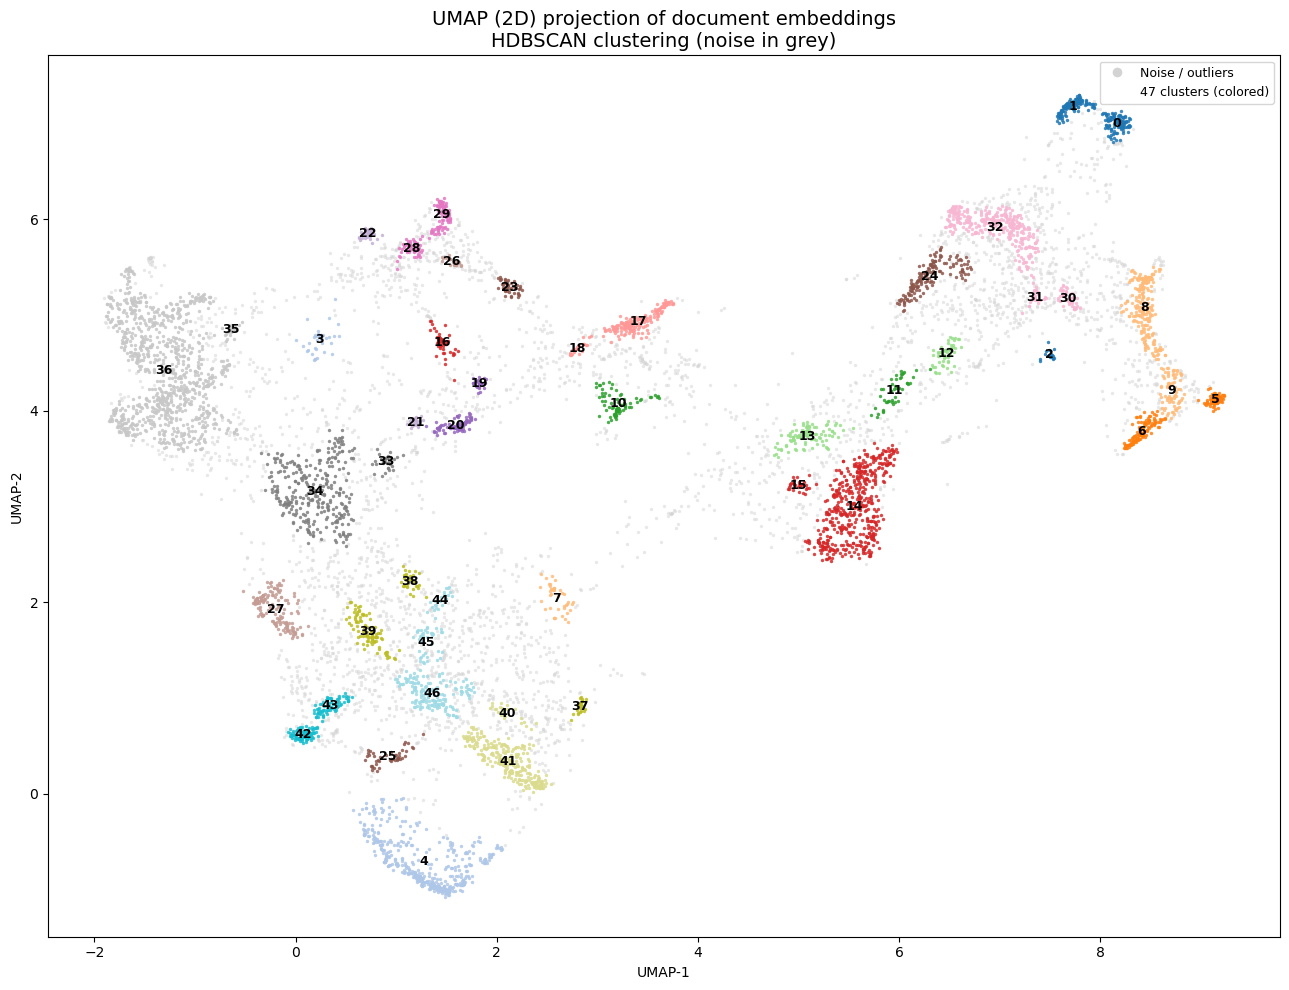

In [34]:
# If you already have Z_full and labels_full in memory, you can skip loading.
Z_2d = np.load("output/modeling/umap_coords_full.npy")      # shape (n_docs, 2)
labels = np.load("output/modeling/hdbscan_labels_full.npy") # shape (n_docs,)

print("Z_2d:", Z_2d.shape, " labels:", labels.shape)
print("n clusters (excluding noise):", len(set(labels)) - (1 if -1 in labels else 0))
print("noise ratio:", (labels == -1).mean())

def plot_umap_2d_enhanced(
    Z,
    labels,
    title="UMAP (2D) projection with HDBSCAN clusters",
    label_top_n=200,
    point_size=6,
    alpha=0.85
):
    """
    Enhanced 2D UMAP visualization with:
    - clusters colored
    - noise (-1) in grey
    - legend
    - cluster number labels at centroids (top N largest clusters)
    """

    Z = np.asarray(Z)
    labels = np.asarray(labels)

    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

    # Count cluster sizes (exclude noise)
    cluster_sizes = Counter(labels[labels != -1])
    largest_clusters = [c for c, _ in cluster_sizes.most_common(label_top_n)]

    # Colormap for clusters
    cmap = plt.cm.get_cmap("tab20", n_clusters)
    cluster_color_map = {
        c: cmap(i) for i, c in enumerate(sorted(cluster_sizes.keys()))
    }

    # --- Plot ---
    plt.figure(figsize=(13, 10))

    # 1) Plot noise first (background)
    noise_mask = labels == -1
    plt.scatter(
        Z[noise_mask, 0],
        Z[noise_mask, 1],
        c="lightgrey",
        s=point_size,
        alpha=0.5,
        label="Noise / outliers",
        linewidths=0
    )

    # 2) Plot clusters
    for c in sorted(cluster_sizes.keys()):
        mask = labels == c
        plt.scatter(
            Z[mask, 0],
            Z[mask, 1],
            s=point_size,
            alpha=alpha,
            color=cluster_color_map[c],
            linewidths=0
        )

    # 3) Label cluster centroids (top N clusters)
    for c in largest_clusters:
        idx = np.where(labels == c)[0]
        if len(idx) == 0:
            continue
        cx, cy = Z[idx, 0].mean(), Z[idx, 1].mean()
        plt.text(
            cx,
            cy,
            str(int(c)),
            fontsize=9,
            weight="bold",
            ha="center",
            va="center",
            color="black"
        )

    # --- Legend (minimal & clean) ---
    legend_elements = [
        Line2D(
            [0], [0],
            marker="o",
            color="w",
            label="Noise / outliers",
            markerfacecolor="lightgrey",
            markersize=8
        ),
        Line2D(
            [0], [0],
            linestyle="none",
            label=f"{n_clusters} clusters (colored)",
            marker=""
        )
    ]

    plt.legend(
        handles=legend_elements,
        loc="best",
        frameon=True,
        fontsize=9
    )

    # --- Titles & layout ---
    plt.title(title, fontsize=14)
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.tight_layout()
    plt.savefig('output/figures/umap_hdbscan_2d_enhanced.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_umap_2d_enhanced(
    Z_2d,
    labels,
    title="UMAP (2D) projection of document embeddings\nHDBSCAN clustering (noise in grey)",
    label_top_n=100,   # adjust for readability
    point_size=6,
    alpha=0.85
)


## Cluster Reduction and Visualization-Oriented Consolidation

The initial application of HDBSCAN on the UMAP-reduced embedding space resulted in a relatively large number of clusters. While this level of granularity is useful for fine-grained exploratory analysis, it is not always suitable for global visualization or higher-level interpretation.

Unlike centroid-based clustering algorithms (e.g., K-Means), HDBSCAN does not provide a direct mechanism to enforce a predefined number of clusters. The number of clusters is instead inferred from the density structure of the data. Consequently, to obtain a more interpretable representation, a post-hoc cluster consolidation step is applied.

Specifically, the centroids of the original HDBSCAN clusters are computed in the two-dimensional UMAP space. These centroids are then clustered using agglomerative hierarchical clustering, allowing multiple original clusters to be merged into a fixed number of higher-level clusters. In this study, the number of merged clusters is set to a maximum of 20.

It is important to note that this consolidation procedure is not intended to be a fully rigorous re-clustering of the original data, nor does it replace the density-based discovery performed by HDBSCAN. Instead, it should be understood as a pragmatic, visualization- and interpretation-oriented transformation. Noise points identified by HDBSCAN are preserved as outliers and are not forced into any merged cluster.

This reduction in cluster cardinality is motivated by downstream analytical needs, particularly the refinement of topic labels using large language models (LLMs). From an interpretability standpoint, generating and validating semantic labels for approximately 20 clusters is considerably more tractable and meaningful than doing so for over +50 (or even more) fine-grained clusters. The reduced clustering therefore facilitates clearer thematic interpretation while retaining the structural information uncovered by the original density-based clustering.


Merged clusters (excluding noise): 20
Noise ratio still: 0.36774484390848644


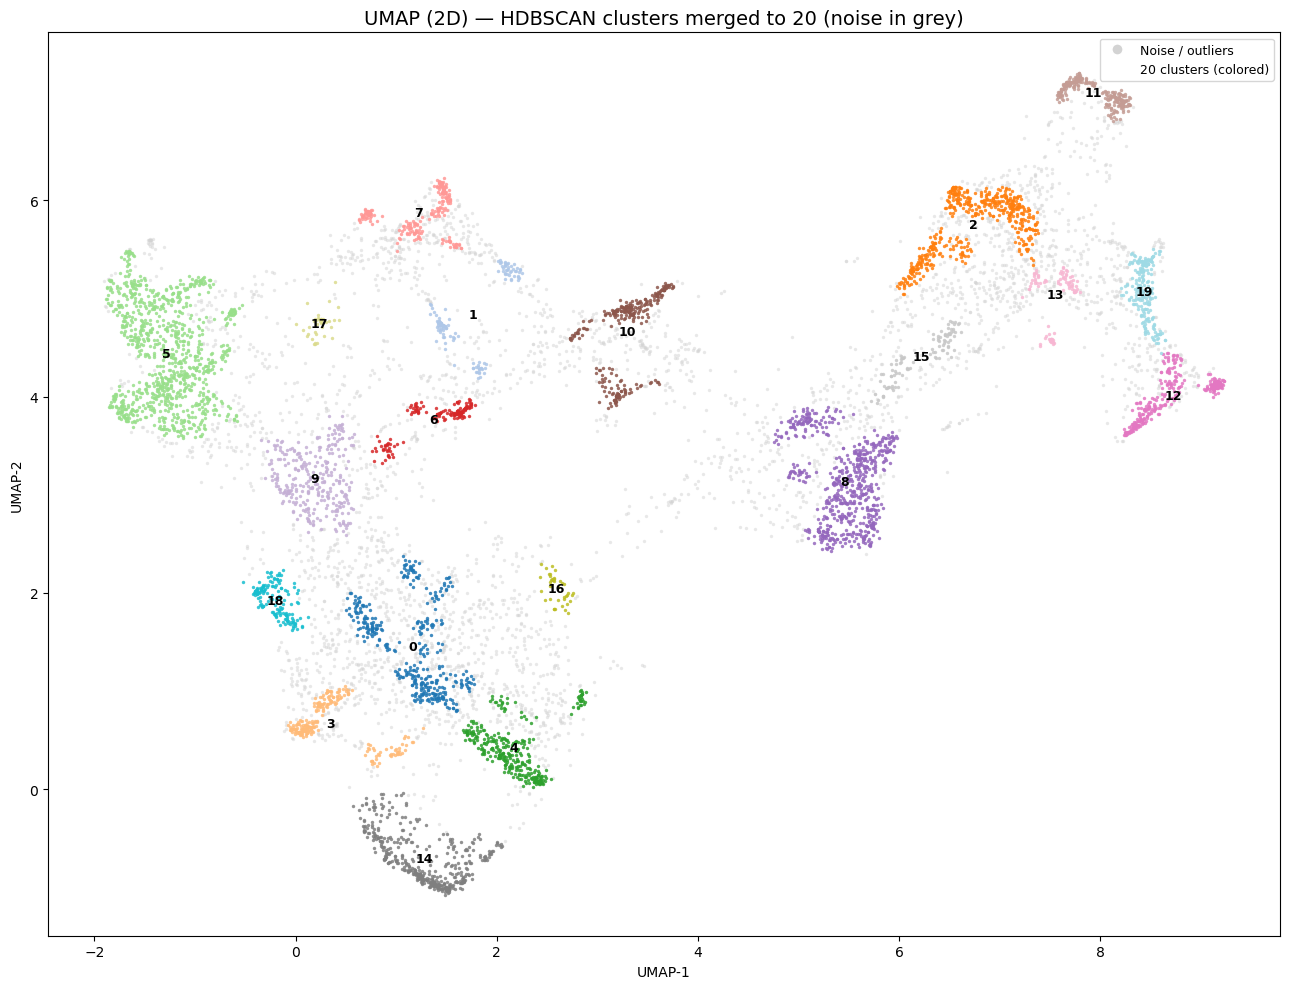

In [35]:
def merge_hdbscan_to_k(Z_2d, labels, k=20):
    """
    Merge HDBSCAN clusters down to exactly k clusters by clustering the cluster centroids.
    - Z_2d: UMAP coordinates (n,2)
    - labels: HDBSCAN labels (n,), noise = -1
    Returns:
      merged_labels: (n,) with labels in [0..k-1], noise remains -1
      centroid_df: dataframe of original cluster centroids + merged cluster assignment
    """
    Z_2d = np.asarray(Z_2d)
    labels = np.asarray(labels)

    # original (non-noise) clusters
    orig_clusters = np.array(sorted([c for c in np.unique(labels) if c != -1]))
    n_orig = len(orig_clusters)

    if n_orig <= k:
        print(f"Already <= {k} clusters (found {n_orig}). No merge performed.")
        return labels.copy(), None

    # compute centroids for each original cluster
    centroids = []
    sizes = []
    for c in orig_clusters:
        idx = np.where(labels == c)[0]
        centroids.append(Z_2d[idx].mean(axis=0))
        sizes.append(len(idx))

    centroids = np.vstack(centroids)  # (n_orig, 2)
    sizes = np.array(sizes)

    # cluster centroids into k groups
    agg = AgglomerativeClustering(n_clusters=k, linkage="ward")
    merged_cluster_ids = agg.fit_predict(centroids)  # (n_orig,)

    # map original cluster -> merged cluster id
    mapping = {orig_clusters[i]: int(merged_cluster_ids[i]) for i in range(n_orig)}

    # build merged labels for each point
    merged_labels = labels.copy()
    for c in orig_clusters:
        merged_labels[labels == c] = mapping[c]

    # keep noise as -1
    merged_labels[labels == -1] = -1

    centroid_df = pd.DataFrame({
        "orig_cluster": orig_clusters,
        "size": sizes,
        "centroid_x": centroids[:, 0],
        "centroid_y": centroids[:, 1],
        "merged_cluster": merged_cluster_ids
    }).sort_values(["merged_cluster", "size"], ascending=[True, False])

    return merged_labels, centroid_df

merged_labels_20, centroid_map = merge_hdbscan_to_k(Z_2d, labels, k=20)

print("Merged clusters (excluding noise):", len(set(merged_labels_20)) - (1 if -1 in merged_labels_20 else 0))
print("Noise ratio still:", (merged_labels_20 == -1).mean())
centroid_map.head()

plot_umap_2d_enhanced(
    Z_2d,
    merged_labels_20,
    title="UMAP (2D) — HDBSCAN clusters merged to 20 (noise in grey)",
    label_top_n=20,
    point_size=6,
    alpha=0.85
)

# save merged labels
np.save("output/modeling/hdbscan_merged_labels_20.npy", merged_labels_20)

## Step 4: *Vectorizer Model*
---

### Why Vectorization?

At this stage, documents have been grouped into clusters using a density-based approach (HDBSCAN), followed by a cluster consolidation step to improve interpretability. While each document is now associated with a cluster identifier, these identifiers are not directly interpretable.

To move from numerical clusters to **human-readable topic representations**, it is necessary to analyze the textual content of documents within each cluster. This is achieved through vectorization, which transforms raw text into a structured numerical representation based on word occurrences.

The vectorizer model prepares the data for the subsequent **class-based TF–IDF (c-TF-IDF)** step, whose objective is to identify the most representative terms for each cluster.

### The CountVectorizer Approach

We use `CountVectorizer` from scikit-learn to construct a **bag-of-words representation** of the clustered documents. Specifically, the vectorizer is used to:

- **Tokenize** the text into words and n-grams
- **Count** term occurrences within each cluster
- **Filter** uninformative terms based on frequency thresholds
- **Build** a document-term matrix where rows correspond to clusters and columns correspond to terms

This approach allows each cluster to be represented as a single aggregated document composed of all texts assigned to that cluster.

### Key Parameters

The following parameters are used for vectorization:

- `ngram_range=(1, 2)`: Extract both unigrams (e.g., "milk") and bigrams (e.g., "dairy cattle")
- `stop_words="english"`: Remove common English stop words
- `min_df=2`: Ignore terms appearing in fewer than two documents
- `max_df=0.95`: Ignore overly common terms appearing in more than 95% of documents
- `max_features=10000`: Retain the 10,000 most frequent terms

These choices balance vocabulary richness with noise reduction and computational efficiency.

### Output

The vectorizer produces:
1. A **vocabulary** containing the selected terms
2. A **count matrix** (clusters × terms) representing word frequencies per cluster
3. A structured input that will be used in the next step to compute **c-TF-IDF scores** and extract representative keywords for each topic


In [36]:
# Step 4: Vectorizer Model — FINALIZED (with correct saved outputs)
os.makedirs("output/modeling", exist_ok=True)

# Load merged labels and documents
merged_labels_20 = np.load("output/modeling/hdbscan_merged_labels_20.npy")

cleaned_df = pd.read_csv("data/cleaned_combined_dataset.csv")
cleaned_abstracts = cleaned_df["Cleaned_Abstract"].fillna("").astype(str).tolist()

assert len(merged_labels_20) == len(cleaned_abstracts), \
    "Mismatch between number of labels and number of documents."

# Create document-level DataFrame
df_vec = pd.DataFrame({
    "text": cleaned_abstracts,
    "cluster": merged_labels_20
})

# Exclude noise points
df_vec = df_vec[df_vec["cluster"] != -1]

# Aggregate documents per cluster (cluster-level documents)
cluster_documents = (
    df_vec
    .groupby("cluster")["text"]
    .apply(lambda texts: " ".join(texts))
    .sort_index()
)

print("Number of clusters vectorized:", cluster_documents.shape[0])

# ------------------------------------------------------------------
# Vectorization
# ------------------------------------------------------------------
vectorizer = CountVectorizer(
    ngram_range=(1, 2),
    stop_words="english",
    min_df=2,
    max_df=0.95,
    max_features=10000,
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b"  # alphabetic tokens only
)

X_counts = vectorizer.fit_transform(cluster_documents)

print("Count matrix shape (clusters × terms):", X_counts.shape)

vocab = vectorizer.get_feature_names_out()
print("Vocabulary size:", len(vocab))
print("Example terms:", vocab[:20])

# ------------------------------------------------------------------
# SAVE ALL REQUIRED OUTPUTS
# ------------------------------------------------------------------

# 1) Count matrix (dense, for c-TF-IDF)
np.save(
    "output/modeling/count_matrix_clusters.npy",
    X_counts.toarray()
)

# 2) Vectorizer model (for vocabulary + reuse)
with open("output/modeling/vectorizer_model.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# 3) Cluster ID mapping (row order is CRITICAL)
np.save(
    "output/modeling/cluster_ids.npy",
    cluster_documents.index.to_numpy()
)

# 4) Vocabulary (human-readable)
pd.Series(vocab).to_csv(
    "output/modeling/vectorizer_vocabulary.csv",
    index=False,
    header=["term"]
)

print("✓ Saved:")
print("  - output/modeling/count_matrix_clusters.npy")
print("  - output/modeling/vectorizer_model.pkl")
print("  - output/modeling/cluster_ids.npy")
print("  - output/modeling/vectorizer_vocabulary.csv")

Number of clusters vectorized: 20
Count matrix shape (clusters × terms): (20, 10000)
Vocabulary size: 10000
Example terms: ['aa' 'aac' 'aat' 'ab' 'ababa' 'abattoir' 'abattoirs' 'abdominal'
 'abdominal obesity' 'abi' 'abilities' 'able' 'abnormal' 'abnormalities'
 'abomasal' 'abomasum' 'aborted' 'abortion' 'abortions' 'abortus']
✓ Saved:
  - output/modeling/count_matrix_clusters.npy
  - output/modeling/vectorizer_model.pkl
  - output/modeling/cluster_ids.npy
  - output/modeling/vectorizer_vocabulary.csv


## Step number 5: *c-TF-IDF (class-based TF-IDF)*
---

### What is c-TF-IDF?

c-TF-IDF (class-based Term Frequency-Inverse Document Frequency) is the **core innovation of BERTopic**. It's a modified version of the traditional TF-IDF algorithm that works at the **cluster/topic level** instead of the individual document level.

### Why is it Important?

At this stage, we have:
- Clusters of similar documents (topics)
- Word counts for each topic (from the vectorizer)

But we still need to answer: **Which words best characterize each topic?**

The challenge is that common words like "study", "results", or "milk" might appear in ALL topics. We need to identify words that are **distinctive** to specific topics.

### Traditional TF-IDF vs c-TF-IDF

**Traditional TF-IDF** (document-level):
```
TF-IDF = (term frequency in document) × log(total docs / docs containing term)
```

**c-TF-IDF** (cluster/topic-level):
```
c-TF-IDF = (term frequency in topic) × log(1 + average_words_per_topic / total_frequency_across_topics)
```

### How c-TF-IDF Works

1. **TF (Term Frequency)**: Calculate how frequently each word appears in each topic
2. **IDF (Inverse Document Frequency)**: Calculate how unique a word is to a specific topic
3. **c-TF-IDF Score**: Multiply TF × IDF to get the importance score

Words get **high c-TF-IDF scores** when they:
- Appear frequently in one specific topic 
- Don't appear much in other topics 

Words get **low c-TF-IDF scores** when they:
- Appear in many topics (too generic) 

### Expected Output

After this step, we will have **human-readable topic descriptions** like:

- **Topic 0**: milk, dairy, production, cows, lactation
- **Topic 3**: mastitis, infection, udder, treatment, bacteria
- **Topic 6**: feed, nutrition, diet, intake, silage

These top words per topic allow us to **understand and interpret** what each cluster represents!

In [37]:
# ------------------------------------------------------------
# 5.1) Load vectorizer + count matrix (clusters × vocabulary)
# ------------------------------------------------------------
VEC_PATH = "output/modeling/vectorizer_model.pkl"
X_PATH   = "output/modeling/count_matrix_clusters.npy"

with open(VEC_PATH, "rb") as f:
    vectorizer_model = pickle.load(f)

X = np.load(X_PATH).astype(float)  # dense array: (n_clusters, n_terms)
feature_names = vectorizer_model.get_feature_names_out()

print(f"Count matrix shape (clusters × vocabulary): {X.shape}")
print(f"Number of clusters/topics: {X.shape[0]}")
print(f"Vocabulary size: {X.shape[1]}")

# ------------------------------------------------------------
# 5.2) Load cluster IDs ordering (recommended for correct mapping)
# ------------------------------------------------------------
CLUSTER_IDS_PATH = "output/modeling/cluster_ids.npy"
if os.path.exists(CLUSTER_IDS_PATH):
    cluster_ids = np.load(CLUSTER_IDS_PATH).tolist()
    assert len(cluster_ids) == X.shape[0], "cluster_ids length does not match number of rows in X."
    print("✓ Loaded cluster_ids mapping:", cluster_ids)
else:
    cluster_ids = list(range(X.shape[0]))
    print("⚠ cluster_ids.npy not found; assuming cluster IDs are 0..n_clusters-1.")

# ------------------------------------------------------------
# 5.3) Compute c-TF-IDF (robust BERTopic-style variant)
# ------------------------------------------------------------
# TF: normalize counts per cluster (row)
words_per_cluster = X.sum(axis=1, keepdims=True)
words_per_cluster[words_per_cluster == 0] = 1.0
tf = X / words_per_cluster

print(f"\nWords per cluster (first 5 rows): {words_per_cluster[:5].flatten()}")

# IDF: based on RAW term frequency across clusters
avg_words_per_cluster = words_per_cluster.mean()
term_freq_across_clusters = X.sum(axis=0)  # raw counts across clusters

idf = np.log((1.0 + avg_words_per_cluster) / (1.0 + term_freq_across_clusters)) + 1.0

# c-TF-IDF
c_tf_idf = tf * idf

print(f"\nc-TF-IDF matrix shape: {c_tf_idf.shape}")
print(f"c-TF-IDF range: [{np.nanmin(c_tf_idf):.6f}, {np.nanmax(c_tf_idf):.6f}]")

# Save
CTFIDF_PATH = "output/modeling/c_tf_idf_matrix.npy"
np.save(CTFIDF_PATH, c_tf_idf)
print(f"\n✓ c-TF-IDF matrix saved to '{CTFIDF_PATH}'")

# ------------------------------------------------------------
# 5.4) Helper: top-N words per topic row
# ------------------------------------------------------------
def get_top_n_words(row_idx, n=10):
    scores = c_tf_idf[row_idx]
    top_idx = np.argsort(scores)[-n:][::-1]
    return [(feature_names[i], float(scores[i])) for i in top_idx]

# ------------------------------------------------------------
# 5.5) Cluster sizes (use merged labels, not old cluster_labels.npy)
# ------------------------------------------------------------
if "merged_labels_20" in globals():
    labels = np.asarray(merged_labels_20)
    print("\n✓ Using merged_labels_20 from memory for cluster sizes.")
else:
    MERGED_LABELS_PATH = "output/modeling/merged_labels_20.npy"
    if not os.path.exists(MERGED_LABELS_PATH):
        raise FileNotFoundError(
            "merged_labels_20 not found in memory and output/modeling/merged_labels_20.npy does not exist. "
            "Save merged labels before running this step."
        )
    labels = np.load(MERGED_LABELS_PATH)
    print("\n✓ Loaded merged labels from output/modeling/merged_labels_20.npy")

cluster_sizes_dict = {cid: int(np.sum(labels == cid)) for cid in cluster_ids}

# Sort by size
topic_row_indices = sorted(
    range(X.shape[0]),
    key=lambda row_i: cluster_sizes_dict.get(cluster_ids[row_i], 0),
    reverse=True
)

# ------------------------------------------------------------
# 5.6) Print topic representations
# ------------------------------------------------------------
print(f"\n{'='*80}")
print("TOPIC REPRESENTATIONS (Top 10 words per topic)")
print(f"{'='*80}\n")

for row_i in topic_row_indices:
    cid = cluster_ids[row_i]
    n_docs = cluster_sizes_dict.get(cid, 0)
    top_words = get_top_n_words(row_i, n=10)

    print(f"Cluster {cid} ({n_docs} documents):")
    for word, score in top_words:
        print(f"  {word:30s} (score: {score:.4f})")
    print()

# ------------------------------------------------------------
# 5.7) Save topic representations (Top 20 words per cluster id)
# ------------------------------------------------------------
topic_representations = {}
for row_i in range(X.shape[0]):
    cid = cluster_ids[row_i]
    top_words = get_top_n_words(row_i, n=20)
    topic_representations[cid] = [w for w, _ in top_words]

REP_PATH = "output/modeling/topic_representations.pkl"
with open(REP_PATH, "wb") as f:
    pickle.dump(topic_representations, f)
print(f"✓ Topic representations saved to '{REP_PATH}'")

# ------------------------------------------------------------
# 5.8) Save a summary CSV
# ------------------------------------------------------------
summary_data = []
for row_i in topic_row_indices:
    cid = cluster_ids[row_i]
    n_docs = cluster_sizes_dict.get(cid, 0)
    top_words_5 = get_top_n_words(row_i, n=5)
    top_words_str = ", ".join([w for w, _ in top_words_5])

    summary_data.append({
        "Cluster": cid,
        "Size": n_docs,
        "Top_Words": top_words_str
    })

summary_df = pd.DataFrame(summary_data)
SUMMARY_PATH = "output/modeling/topic_summary.csv"
summary_df.to_csv(SUMMARY_PATH, index=False)

print(f"\n✓ Topic summary saved to '{SUMMARY_PATH}'")
print("\nTopic Summary:")
print(summary_df.to_string(index=False))

Count matrix shape (clusters × vocabulary): (20, 10000)
Number of clusters/topics: 20
Vocabulary size: 10000
✓ Loaded cluster_ids mapping: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

Words per cluster (first 5 rows): [47708. 12147. 57591. 25593. 44035.]

c-TF-IDF matrix shape: (20, 10000)
c-TF-IDF range: [0.000000, 0.144660]

✓ c-TF-IDF matrix saved to 'output/modeling/c_tf_idf_matrix.npy'

✓ Using merged_labels_20 from memory for cluster sizes.

TOPIC REPRESENTATIONS (Top 10 words per topic)

Cluster 5 (968 documents):
  cattle                         (score: 0.0693)
  animals                        (score: 0.0345)
  infection                      (score: 0.0324)
  bovine                         (score: 0.0295)
  prevalence                     (score: 0.0280)
  species                        (score: 0.0260)
  virus                          (score: 0.0227)
  brucellosis                    (score: 0.0208)
  livestock                      (score: 0.0204)
  bov

## Step 9.1: Fine-tune Topic Representations with LLM
---

### Goal: Use LLM to Refine Topic Titles and Link to Determinants of Health (DoH)

We will use Meta-Llama-3.2-1B-Instruct (https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct) to:
1. Analyze the most representative documents (closest to centroids) for each cluster
2. Consider the top 20 characteristic words from c-TF-IDF
3. Generate refined topic titles with confidence scores
4. Identify 5 Determinants of Health factors related to dairy cattle for each topic

This approach combines:
- **Quantitative analysis** (embeddings, c-TF-IDF scores)
- **Qualitative interpretation** (LLM understanding of scientific abstracts)

In [39]:
print("="*80)
print("STEP 9: FINE-TUNE TOPIC REPRESENTATIONS WITH LLM")
print("Using Llama-3.2-1B-Instruct")
print("="*80)

# Login to HuggingFace (if not already done)
print("\n1. Checking HuggingFace authentication...")
try:
    login(token=None)  # Will use cached token if available
    print("   ✓ Already logged in")
except:
    print("   Logging in...")
    login()

# Set device
device = "cpu"
print(f"\n2. Using device: {device}")

# Load Llama-3.2-1B model
MODEL_NAME = "meta-llama/Llama-3.2-1B-Instruct"
print(f"\n3. Loading model: {MODEL_NAME}")
print("   Model size: 1B parameters (~2GB)")
print("   Specialty: Instruction-tuned Llama model")
print("   This may take a few minutes...")

start_time = time.time()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float32,  # Use float32 for CPU
    low_cpu_mem_usage=True
)

model = model.to(device)
model.eval()

load_time = time.time() - start_time
print(f"   ✓ Model loaded successfully in {load_time:.1f} seconds!")
print()

STEP 6: FINE-TUNE TOPIC REPRESENTATIONS WITH LLM
Using Llama-3.2-1B-Instruct

1. Checking HuggingFace authentication...


   ✓ Already logged in

2. Using device: cpu

3. Loading model: meta-llama/Llama-3.2-1B-Instruct
   Model size: 1B parameters (~2GB)
   Specialty: Instruction-tuned Llama model
   This may take a few minutes...
   ✓ Model loaded successfully in 12.7 seconds!



In [40]:
print("="*80)
print("Loading necessary data (updated pipeline outputs)...")
print("="*80)

# --- Load merged cluster labels (doc-level) ---
MERGED_LABELS_PATH = "output/modeling/hdbscan_merged_labels_20.npy"
cluster_labels = np.load(MERGED_LABELS_PATH)

# --- Load 2D UMAP coordinates (doc-level) for centroid selection ---
UMAP_2D_PATH = "output/modeling/umap_coords_full.npy"
umap_2d = np.load(UMAP_2D_PATH)

# --- Load c-TF-IDF (cluster-level) ---
CTFIDF_PATH = "output/modeling/c_tf_idf_matrix.npy"
c_tf_idf = np.load(CTFIDF_PATH)

# --- Load vectorizer model ---
VEC_PATH = "output/modeling/vectorizer_model.pkl"
with open(VEC_PATH, "rb") as f:
    vectorizer_model = pickle.load(f)

feature_names = vectorizer_model.get_feature_names_out()

# --- Load cluster_ids mapping (CRITICAL: row i in c_tf_idf corresponds to cluster_ids[i]) ---
CLUSTER_IDS_PATH = "output/modeling/cluster_ids.npy"
cluster_ids = np.load(CLUSTER_IDS_PATH)

# --- Load abstracts ---
cleaned_df = pd.read_csv("data/cleaned_combined_dataset.csv")
docs = cleaned_df["Cleaned_Abstract"].fillna("").astype(str).tolist()

# --- Sanity checks ---
assert len(docs) == len(cluster_labels) == umap_2d.shape[0], "Docs/labels/UMAP length mismatch."
assert c_tf_idf.shape[0] == len(cluster_ids), "c_tf_idf rows must match cluster_ids length."

print(f"✓ Data loaded successfully!")
print(f"  - Documents: {len(docs)}")
print(f"  - UMAP 2D coords: {umap_2d.shape}")
print(f"  - Clusters (max): {len(cluster_ids)}")
print(f"  - c-TF-IDF topics: {c_tf_idf.shape[0]}")
print(f"  - Vocabulary size: {len(feature_names)}")
print(f"  - Noise ratio: {(cluster_labels == -1).mean():.3f}")
print()


print("="*80)
print("Defining helper functions...")
print("="*80)

def get_closest_documents_to_centroid(cluster_id, coords_2d, labels, docs, n=5):
    """
    Find the n documents closest to the cluster centroid in UMAP 2D space.
    Excludes noise points by construction (cluster_id should not be -1).
    Uses cosine distance for stable ranking.
    """
    mask = labels == cluster_id
    if mask.sum() == 0:
        return []

    cluster_coords = coords_2d[mask]
    cluster_doc_indices = np.where(mask)[0]

    centroid = cluster_coords.mean(axis=0, keepdims=True)  # shape (1, 2)

    dists = cosine_distances(cluster_coords, centroid).ravel()
    closest_local = np.argsort(dists)[:n]
    closest_doc_indices = cluster_doc_indices[closest_local]

    return [docs[idx] for idx in closest_doc_indices]


def get_top_n_words_for_topic_row(topic_row_idx, c_tf_idf, feature_names, n=20):
    """
    Get top N words from c-TF-IDF for a given topic row index (0..n_topics-1).
    """
    topic_scores = c_tf_idf[topic_row_idx]
    top_indices = np.argsort(topic_scores)[-n:][::-1]
    return [feature_names[idx] for idx in top_indices]


print("✓ Helper functions defined!\n")
print()

# Prompt Engineering Function
print("="*80)
print("Defining prompt engineering function...")
print("="*80)

def create_llm_prompt(topic_id, top_abstracts, top_words):
    """
    Create a structured prompt for the LLM to analyze topics
    
    Args:
        topic_id: ID of the topic being analyzed
        top_abstracts: List of representative abstracts
        top_words: List of characteristic words from c-TF-IDF
    
    Returns:
        Formatted prompt string
    """
    # Truncate abstracts to avoid token limits
    abstracts_text = "\n\n".join([f"Abstract {i+1}: {abstract[:500]}..." 
                                   for i, abstract in enumerate(top_abstracts)])
    words_text = ", ".join(top_words)
    
    prompt = f"""You are an expert in veterinary public health and dairy cattle research. Analyze the following topic information and provide a structured response. If the information is insufficient, indicate that clearly.

**Topic ID:** {topic_id}

**Top 20 Characteristic Words:**
{words_text}

**5 Most Representative Abstracts:**
{abstracts_text}

Based on this information, please provide:

1. **Refined Topic Title**: A clear, concise title (5-10 words) that captures the main theme
2. **Key Words Used**: List 5-7 key words from the characteristic words that best support your title
3. **Confidence Score**: Rate your confidence in this title (0-100)
4. **Determinants of Health (DoH) for Dairy Cattle**: List 5 specific factors or indicators that link this topic to health determinants for dairy cattle.

Provide your response in the following JSON format:
{{
  "refined_title": "Your refined title here",
  "key_words": ["word1", "word2", "word3", "word4", "word5"],
  "confidence_score": 85,
  "doh_factors": [
    "Factor 1: Description",
    "Factor 2: Description",
    "Factor 3: Description",
    "Factor 4: Description",
    "Factor 5: Description"
  ]
}}

Respond ONLY with the JSON, no additional text."""
    
    return prompt

print("✓ Prompt engineering function defined!")
print()

# LLM Query Function
print("="*80)
print("Defining LLM query function...")
print("="*80)

# LLM Query Function (TinyLlama style)

def query_llm(prompt, max_new_tokens=512):
    """
    Query TinyLlama using official chat template format
    """
    # Format as chat messages
    messages = [
        {"role": "system", "content": "You are a helpful assistant that analyzes biomedical topics and provides structured JSON responses."},
        {"role": "user", "content": prompt}
    ]
    
    # Apply chat template (following official example)
    inputs = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
    ).to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
    
    # Decode only the new tokens (remove input prompt)
    response = tokenizer.decode(outputs[0][inputs["input_ids"].shape[-1]:], skip_special_tokens=True)
    
    return response.strip()

print("✓ LLM query function defined!")
print()
print("="*80)
print("All functions ready! You can now process topics.")
print("="*80)
print()

Loading necessary data (updated pipeline outputs)...
✓ Data loaded successfully!
  - Documents: 8873
  - UMAP 2D coords: (8873, 2)
  - Clusters (max): 20
  - c-TF-IDF topics: 20
  - Vocabulary size: 10000
  - Noise ratio: 0.368

Defining helper functions...
✓ Helper functions defined!


Defining prompt engineering function...
✓ Prompt engineering function defined!

Defining LLM query function...
✓ LLM query function defined!

All functions ready! You can now process topics.



In [41]:
print("="*80)
print("TESTING FIRST CLUSTER PROCESSING")
print("="*80)

# "First cluster" according to our saved mapping:
# row 0 in c_tf_idf corresponds to cluster_ids[0]
test_topic_row_idx = 0
test_cluster_id = int(cluster_ids[test_topic_row_idx])

print(f"\nTest topic row index: {test_topic_row_idx}")
print(f"Mapped cluster ID: {test_cluster_id}")

# Get data for the test cluster
print("\n1. Extracting cluster data...")

top_abstracts = get_closest_documents_to_centroid(
    test_cluster_id,
    umap_2d,            # <-- 2D UMAP coordinates
    cluster_labels,     # <-- merged labels (doc-level)
    docs,
    n=5
)

top_words = get_top_n_words_for_topic_row(
    test_topic_row_idx, # <-- row index, not cluster id
    c_tf_idf,
    feature_names,
    n=20
)

print(f"     Top words (first 10): {', '.join(top_words[:10])}")
print(f"     Number of abstracts retrieved: {len(top_abstracts)}")

# Create prompt
print("\n2. Creating prompt...")
prompt = create_llm_prompt(test_cluster_id, top_abstracts, top_words)
print(f"     Prompt length: {len(prompt)} characters")

print("\n   Prompt preview (first 300 chars):")
print("   " + "-"*76)
print("   " + prompt[:300].replace("\n", "\n   "))
print("   ...")
print("   " + "-"*76)

# Query LLM
print("\n3. Querying LLM...")
start_time = time.time()

response = query_llm(prompt, max_new_tokens=400)

elapsed = time.time() - start_time
print(f"     Response generated in {elapsed:.1f} seconds")

# Display raw response
print("\n4. Raw LLM response:")
print("="*80)
print(response)
print("="*80)
print(f"   Response length: {len(response)} characters")

# Try to parse JSON
print("\n5. Attempting JSON parsing...")
try:
    response_clean = response.strip()

    # Remove markdown code blocks if any
    if response_clean.startswith("```json"):
        response_clean = response_clean[7:]
    if response_clean.startswith("```"):
        response_clean = response_clean[3:]
    if response_clean.endswith("```"):
        response_clean = response_clean[:-3]
    response_clean = response_clean.strip()

    # Extract JSON object (robust approach)
    start_idx = response_clean.find("{")
    end_idx = response_clean.rfind("}")

    if start_idx != -1 and end_idx != -1 and end_idx > start_idx:
        json_str = response_clean[start_idx:end_idx + 1]

        print("   Extracted JSON string (first 500 chars):")
        print("   " + "-"*76)
        print("   " + json_str[:500].replace("\n", "\n   "))
        if len(json_str) > 500:
            print("   ...")
        print("   " + "-"*76)

        result = json.loads(json_str)

        print("\n     JSON PARSING SUCCESSFUL!")
        print("\n" + "="*80)
        print("PARSED RESULTS:")
        print("="*80)
        print(f"\nCluster ID: {test_cluster_id}")
        print(f"Refined Title: {result.get('refined_title', 'N/A')}")
        print(f"Confidence Score: {result.get('confidence_score', 0)}")

        key_words = result.get("key_words", [])
        if key_words:
            print("\nKey Words:")
            for i, word in enumerate(key_words, 1):
                print(f"  {i}. {word}")

        doh_factors = result.get("doh_factors", [])
        if doh_factors:
            print("\nDeterminants of Health Factors:")
            for i, factor in enumerate(doh_factors, 1):
                print(f"  {i}. {factor}")

        print("\n" + "="*80)
        print("  TEST SUCCESSFUL! Ready to process all clusters.")
        print("="*80)

    else:
        raise ValueError("No JSON object found in response (missing { } brackets).")

except json.JSONDecodeError as e:
    print("\n     JSON PARSING FAILED!")
    print(f"   Error: {e}")
    print(f"   Position: {e.pos}")
    print(f"   Message: {e.msg}")
    print("\n   The model did not return valid JSON. Consider lowering temperature or adding stricter instructions.")

except Exception as e:
    print(f"\n     ERROR: {str(e)}")
    print("\n   Raw response preview:")
    print("   " + "-"*76)
    print("   " + response[:500].replace("\n", "\n   "))
    print("   " + "-"*76)

TESTING FIRST CLUSTER PROCESSING

Test topic row index: 0
Mapped cluster ID: 0

1. Extracting cluster data...
     Top words (first 10): milk, lactation, mastitis, calving, herd, dairy cows, yield, milk yield, herds, dim
     Number of abstracts retrieved: 5

2. Creating prompt...
     Prompt length: 3915 characters

   Prompt preview (first 300 chars):
   ----------------------------------------------------------------------------
   You are an expert in veterinary public health and dairy cattle research. Analyze the following topic information and provide a structured response. If the information is insufficient, indicate that clearly.
   
   **Topic ID:** 0
   
   **Top 20 Characteristic Words:**
   milk, lactation, mastitis, calving, herd, 
   ...
   ----------------------------------------------------------------------------

3. Querying LLM...
     Response generated in 39.0 seconds

4. Raw LLM response:
{
  "refined_title": "Understanding Dairy Cattle Health Indicators for Optim

In [42]:
print("="*80)
print(f"PROCESSING TOPICS WITH LLM MODEL")
print("="*80)
print()

refined_topics = {}

# cluster_ids: mapping row index -> actual cluster ID
# c_tf_idf rows correspond to cluster_ids order
n_topics = len(cluster_ids)

for topic_row_idx, cluster_id in tqdm(
    list(enumerate(cluster_ids)),
    desc="Refining topics with LLM",
    total=n_topics
):
    cluster_id = int(cluster_id)

    print(f"\n{'='*80}")
    print(f"Processing Cluster {cluster_id} (row {topic_row_idx})")

    # --------------------------------------------------------
    # Representative abstracts (doc-level)
    # --------------------------------------------------------
    top_abstracts = get_closest_documents_to_centroid(
        cluster_id,
        umap_2d,
        cluster_labels,
        docs,
        n=5
    )

    # --------------------------------------------------------
    # Top words (cluster-level, via c-TF-IDF row)
    # --------------------------------------------------------
    top_words = get_top_n_words_for_topic_row(
        topic_row_idx,
        c_tf_idf,
        feature_names,
        n=20
    )

    # --------------------------------------------------------
    # Prompt + LLM query
    # --------------------------------------------------------
    prompt = create_llm_prompt(cluster_id, top_abstracts, top_words)

    try:
        response = query_llm(prompt, max_new_tokens=512)

        # ---------- Clean response ----------
        response_clean = response.strip()

        if response_clean.startswith("```json"):
            response_clean = response_clean[7:]
        if response_clean.startswith("```"):
            response_clean = response_clean[3:]
        if response_clean.endswith("```"):
            response_clean = response_clean[:-3]

        response_clean = response_clean.strip()

        # Extract JSON object safely
        start_idx = response_clean.find("{")
        end_idx = response_clean.rfind("}")

        if start_idx == -1 or end_idx == -1 or end_idx <= start_idx:
            raise ValueError("No valid JSON object found in LLM response.")

        json_str = response_clean[start_idx:end_idx + 1]
        result = json.loads(json_str)

        refined_topics[cluster_id] = result

        print(f"✓ Cluster {cluster_id} processed successfully")
        print(f"  Title: {result.get('refined_title', 'N/A')}")
        print(f"  Confidence: {result.get('confidence_score', 0)}")

    except Exception as e:
        print(f"✗ Error processing Cluster {cluster_id}: {str(e)}")

        refined_topics[cluster_id] = {
            "refined_title": f"Cluster {cluster_id} (LLM Error)",
            "key_words": top_words[:5],
            "confidence_score": 0,
            "doh_factors": ["LLM output could not be parsed"],
            "raw_response": response if "response" in locals() else ""
        }

# ------------------------------------------------------------
# Save full JSON output
# ------------------------------------------------------------
JSON_PATH = "output/llm/refined_topics_llm.json"
with open(JSON_PATH, "w") as f:
    json.dump(refined_topics, f, indent=2)

print(f"\n✓ All topics processed!")
print(f"✓ Results saved to '{JSON_PATH}'")

# ------------------------------------------------------------
# Display detailed results
# ------------------------------------------------------------
print(f"\n{'='*80}")
print("REFINED TOPIC SUMMARY (DETAILED)")
print(f"{'='*80}\n")

for cluster_id in sorted(refined_topics.keys()):
    result = refined_topics[cluster_id]
    n_docs = int(np.sum(cluster_labels == cluster_id))

    print(f"Cluster {cluster_id} ({n_docs} documents)")
    print(f"  Title: {result.get('refined_title', 'N/A')}")
    print(f"  Confidence: {result.get('confidence_score', 0)}")

    key_words = result.get("key_words", [])
    print(f"  Key Words: {', '.join(key_words) if key_words else 'N/A'}")

    print("  DoH Factors:")
    doh_factors = result.get("doh_factors", [])
    if doh_factors:
        for factor in doh_factors:
            print(f"    - {factor}")
    else:
        print("    - N/A")
    print()

# ------------------------------------------------------------
# Create summary CSV
# ------------------------------------------------------------
summary_data = []
for cluster_id in refined_topics.keys():
    result = refined_topics[cluster_id]
    n_docs = int(np.sum(cluster_labels == cluster_id))

    key_words = result.get("key_words", [])
    key_words_str = ", ".join(key_words[:5]) if key_words else "N/A"

    summary_data.append({
        "Cluster_ID": cluster_id,
        "Size": n_docs,
        "Refined_Title": result.get("refined_title", "N/A"),
        "Confidence": result.get("confidence_score", 0),
        "Key_Words": key_words_str
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values("Size", ascending=False)

CSV_PATH = "output/llm/refined_topics_summary.csv"
summary_df.to_csv(CSV_PATH, index=False)

print(f"✓ Summary saved to '{CSV_PATH}'")
print(f"\n{'='*80}")
print("REFINED TOPICS SUMMARY TABLE")
print(f"{'='*80}\n")
print(summary_df.to_string(index=False))
print()

PROCESSING TOPICS WITH LLM MODEL



Refining topics with LLM:   0%|          | 0/20 [00:00<?, ?it/s]


Processing Cluster 0 (row 0)
✓ Cluster 0 processed successfully
  Title: Improved Dairy Cattle Health through Diagnostic Techniques and Genomic Analysis
  Confidence: 90

Processing Cluster 1 (row 1)
✓ Cluster 1 processed successfully
  Title: Assessing Water Quality in Dairy Cattle Production Systems
  Confidence: 90

Processing Cluster 2 (row 2)
✓ Cluster 2 processed successfully
  Title: Association between Dietary Patterns and Bone Health in Dairy Cattle
  Confidence: 90

Processing Cluster 3 (row 3)
✓ Cluster 3 processed successfully
  Title: Genetic Correlations in Dairy Cattle: Impact on Productivity and Traits
  Confidence: 90

Processing Cluster 4 (row 4)
✓ Cluster 4 processed successfully
  Title: Effects of Supplementation on Milk Yield in Dairy Cows
  Confidence: 95

Processing Cluster 5 (row 5)
✓ Cluster 5 processed successfully
  Title: The Impact of Brucellosis on Dairy Cattle Health in Developing Countries
  Confidence: 90

Processing Cluster 6 (row 6)
✓ Cluster 6 proc

## Model Limitations and Considerations

**Critical factors affecting BERTopic performance and results**

### Embedding Model Benefits and Trade-offs
The use of BioBERT for generating document embeddings significantly enhances the model's ability to understand technical veterinary and biomedical terminology. Given the highly specialized nature of dairy cattle health literature, domain-specific embeddings like BioBERT are essential for capturing semantic relationships that general-purpose models might miss. However, even with BioBERT, there may be nuances specific to veterinary science that are better captured by even more specialized embedding models.

### Hyperparameter Optimization Challenge
BERTopic involves numerous hyperparameters across dimensionality reduction, clustering algorithms, c-TF-IDF, and CountVectorizer components. This extensive parameter space makes it difficult to guarantee optimal model configuration, and the current results may not represent the absolute best performance achievable. Without systematic hyperparameter tuning (e.g., grid search or Bayesian optimization), we cannot confidently assert that the discovered topics are the most meaningful representations of the underlying research themes.

### Outlier Assignment and Lost Clusters
In the full-scale project implementation, BERTopic tends to classify a substantial number of documents as outliers (cluster -1). While this conservative approach prevents forcing documents into inappropriate clusters, it likely results in the loss of small but potentially significant research niches. These micro-clusters could represent emerging research areas, highly specialized methodologies, or interdisciplinary work that doesn't fit neatly into major thematic categories but may be highly relevant for comprehensive understanding of the field.

### Reduced Cluster Granularity
For the scope of this demonstration project, the number of topics was limited to 20 clusters arbitrarly. This constraint necessarily reduces the granularity of topic discovery and may force conceptually distinct research areas into broader, less specific categories. A more comprehensive analysis with additional clusters could reveal finer-grained research themes and provide more actionable insights for understanding the full diversity of dairy cattle health research.

### Computational Constraints and LLM Performance
The local deployment of language models is limited by available computational resources. The relatively small LLM (1B) used in this analysis introduces several issues:

- **Topic hallucination:** While all generated topics appear dairy-related, some incorrectly include human health aspects, suggesting potential misclassification of non-dairy cattle research. This indicates that some clusters may contain heterogeneous content that doesn't strictly align with dairy cattle health.
- **Reduced refinement quality:** In the full project implementation using a more powerful 8B parameter model, topic refinement shows significantly better accuracy with fewer hallucinations and more precise topic labeling.
- **Positive outcome:** Despite size limitations, the JSON-formatted output structure works reliably, providing more interpretable and structured topic representations compared to raw c-TF-IDF keyword extraction alone. This structured approach enables better post-processing and visualization of results.

### Representative Sample Limitation
The topic modeling process uses only the top 5 papers closest to each cluster centroid for LLM-based topic refinement and labeling. This approach potentially excludes valuable information from peripheral papers, including:
- Publications that may not actually focus on dairy cattle health despite being clustered together
- Documents at cluster boundaries that represent transitional or interdisciplinary research
- Edge cases that could provide insights into emerging themes or methodological innovations

This sampling strategy prioritizes computational efficiency over comprehensive representation, which may result in topic labels that don't fully capture the diversity within each cluster.

### Additional Methodological Considerations

**Temporal Dynamics**
The model treats all publications uniformly regardless of their publication date. Given the identified data gap between 2009 and 2022, and the evolution of research priorities over time, a static topic model may miss important temporal shifts in research focus, emerging topics, or declining research areas. Dynamic topic modeling approaches could better capture how research themes evolve over the two-decade span.

**Abstract-Only Analysis**
The analysis relies solely on publication abstracts rather than full-text content. Abstracts are often written for broad appeal and may not capture the full methodological depth, specific findings, or nuanced contributions of each paper. This limitation could lead to oversimplified or inaccurate topic assignments, particularly for papers where the abstract emphasizes different aspects than the main research contribution.

**Validation Challenges**
Without domain expert validation or ground truth labels, it's difficult to assess whether the discovered topics align with established veterinary research categories or represent genuinely meaningful thematic groupings. The interpretability of topics relies heavily on qualitative assessment of keyword lists and LLM-generated labels rather than quantitative validation metrics or expert consensus.